In [1]:
import pandas as pd
#math
from string import punctuation
from itertools import product
import numpy as np

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose
#encoder
from sklearn.preprocessing import LabelEncoder
#sys
import time
import datetime
import warnings
warnings.filterwarnings("ignore")

# Visualize
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
from pylab import rcParams
import calmap
import squarify

In [2]:
#Golabl variable
path = "/Users/williamchen/Documents/Kaggle/predict_future_sales/predict_future_sales_data/"

d = {0:57, 1:58, 10:11}

### Quick look at sales_train.csv
#### There are 6 variables in the data including 3 categorical variables and 2(item_price and item_cnt_day) continuous variables.
#### The samples of sales are 2935849.
#### The memories can be reduced.

In [3]:
%%time
sales = pd.read_csv(path + "sales_train.csv")
sales["date"] = pd.to_datetime(sales["date"], format = "%d.%m.%Y")

CPU times: user 1.39 s, sys: 169 ms, total: 1.56 s
Wall time: 1.58 s


In [4]:
sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

In [5]:
# Dimension of sales
print(sales.shape)

(2935849, 6)


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


#### There are some problems in the sales data. The lowest item_price is -1.0 and the loweset item_cnt_day is also negative. 
#### The average of item_cnt_day is about 1.24 and the 25%, 50% and 75% is 1, but the max value is 2169 which means at least one outlier in the data.
#### The date_block_num is from 0 to 33 means the date from 2013/01/01 ~ 2015/10/31

In [7]:
print(sorted(sales.date)[0])
print(sorted(sales.date)[-1])

2013-01-01 00:00:00
2015-10-31 00:00:00


### Quick look at shops.csv
#### There are 4 shops that we have found to duplicates (0:57, 1:58, 10:11, 23:24). 
#### There are 60 shops.
#### Each shop_name starts with the city name.

In [8]:
shops = pd.read_csv(path + "shops.csv")

In [9]:
shops.shape

(60, 2)

In [10]:
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [11]:
shops.loc[shops.shop_id.isin([0,57])]

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
57        Якутск Орджоникидзе, 56       57

In [12]:
shops.loc[shops.shop_id.isin([1,58])]

shop_name  shop_id
1   !Якутск ТЦ "Центральный" фран        1
58        Якутск ТЦ "Центральный"       58

In [13]:
shops.loc[shops.shop_id.isin([10,11])]

shop_name  shop_id
10  Жуковский ул. Чкалова 39м?       10
11  Жуковский ул. Чкалова 39м²       11

In [14]:
shops.loc[shops.shop_id.isin([23,24])]

shop_name  shop_id
23  Москва ТК "Буденовский" (пав.А2)       23
24  Москва ТК "Буденовский" (пав.К7)       24

In [15]:
d = {0:57, 1:58, 10:11}
shops["shop_id"] = shops["shop_id"].apply(lambda x: d[x] if x in d.keys() else x)
# replace all the punctuation in the shop_name columns
shops["shop_name_cleaned"] = shops["shop_name"].apply(lambda s: "".join([x for x in s if x not in punctuation]))
# extract the city name
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
shops["city_id"] = LabelEncoder().fit_transform(shops['city'])
shops["shop_category"] = LabelEncoder().fit_transform(shops['category'])

### Quick look at item_categories and items csv file
#### Each category contains type and subtype in its name. 

In [16]:
cats = pd.read_csv(path + "item_categories.csv")
items = pd.read_csv(path + "items.csv")

In [17]:
item_cats = pd.merge(cats,items, on=["item_category_id"], how='left')

In [18]:
item_cats.head()

item_category_name  item_category_id  \
0  PC - Гарнитуры/Наушники                 0   
1  PC - Гарнитуры/Наушники                 0   
2  PC - Гарнитуры/Наушники                 0   
3  PC - Гарнитуры/Наушники                 0   
4         Аксессуары - PS2                 1   

                                           item_name  item_id  
0  PC: Гарнитура HyperX Cloud Core игровая стерео...     5441  
1                        Наушники PHILIPS SBC HC8680    16255  
2                             Наушники RITMIX RH-120    16256  
3                       Наушники RITMIX RH-124 Black    16257  
4  PS2: Карта памяти 8 Мб черная (Memory Card 8Mb...     5606

In [19]:
print('The number of variables')
print('item_category_id :', len(item_cats.item_category_id.unique()))
print('item__id :', len(item_cats.item_id.unique()))

The number of variables
item_category_id : 84
item__id : 22170


In [20]:
item_cats['split'] = item_cats['item_category_name'].str.split('-')
item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats['type_code'] = LabelEncoder().fit_transform(item_cats['type'])
item_cats['subtype_code'] = LabelEncoder().fit_transform(item_cats['subtype'])

In [21]:
item_cats.sample(5)

item_category_name  item_category_id  \
7497                            Кино - DVD                40   
19673                   Подарки - Развитие                67   
1460                       Игры - XBOX 360                23   
10086                           Кино - DVD                40   
13750  Музыка - CD локального производства                55   

                                               item_name  item_id  \
7497                                          ВПРИТЫК WB    10049   
19673  Мини-головоломка 25***/ Mini Wire 25*** Арт. 4...    15126   
1460            Battlefield 4 [Xbox 360, русская версия]     1858   
10086        ПУТЕШЕСТВИЕ К ЦЕНТРУ ЗЕМЛИ (3D) WB (регион)    17551   
13750  MATSUEV DENIS & NEW YORK PHILHARMONIC  Sergei ...     4571   

                                        split     type  \
7497                            [Кино ,  DVD]     Кино   
19673                   [Подарки ,  Развитие]  Подарки   
1460                       [Игры ,  XBOX 360]     Игры   
10086                           [Кино ,  DVD]     Кино   
13750  [Музыка ,  CD локального производства]   Музыка   

                          subtype  type_code  subtype_code  
7497                          DVD         11             4  
19673                    Развитие         14            52  
1460                     XBOX 360          5            16  
10086                         DVD         11             4  
13750  CD локального производства         13             2

### Quick look at test data

In [22]:
test = pd.read_csv(path+"test.csv",index_col='ID')

In [23]:
# The date is 2015/11/01 ~2015/11/30 and the date_block_num == 34
test.head()

shop_id  item_id
ID                  
0         5     5037
1         5     5320
2         5     5233
3         5     5232
4         5     5268

In [24]:
print('shop_id :',len(test.shop_id.unique()))
print('item_id :',len(test.item_id.unique()))

shop_id : 42
item_id : 5100


In [25]:
sales["shop_id"] = sales["shop_id"].apply(lambda x: d[x] if x in d.keys() else x)
test["shop_id"] = test["shop_id"].apply(lambda x: d[x] if x in d.keys() else x)

### We can discuss that the relation between when the shops or items appear at first time and the item_cnt_month.

In [26]:
# There are 15 shop_ids that test set do not have but exist in sales set.
print(len(set(sales.shop_id.unique()).difference(set(test.shop_id.unique()))))
# There are 17070 item_ids that test set do not have but exist in sales set.
print(len(set(sales.item_id.unique()).difference(set(test.item_id.unique()))))

15
17070


In [27]:
# If we product 33 date_block_num and all of shop_id and item_id we will get 42965460 rows.
len(sales.date_block_num.unique())*len(shops.shop_id.unique())*len(item_cats.item_id.unique())

42965460

### Preparing full data

In [28]:
%%time
# create df by merging the previous dataframes
df = pd.merge(sales,item_cats, on=["item_id"], how='left')
df = pd.merge(df,shops, on=["shop_id"], how='left')
df.sort_values(by = ["date","shop_id","item_id" ], ascending = True, inplace = True)
df.drop(['split','shop_name_cleaned'],axis = 1, inplace = True)
df["YEAR"] = df["date"].dt.year
df['month'] = df["date_block_num"] % 12

CPU times: user 3.79 s, sys: 853 ms, total: 4.64 s
Wall time: 4.66 s


In [29]:
df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
32569 2013-01-01               0        2      991        99.0           1.0   
32552 2013-01-01               0        2     1472      2599.0           1.0   
32632 2013-01-01               0        2     1905       249.0           1.0   
32459 2013-01-01               0        2     2920       599.0           2.0   
32504 2013-01-01               0        2     3320      1999.0           1.0   

                  item_category_name  item_category_id  \
32569             Подарки - Развитие                67   
32552                Игры - XBOX 360                23   
32632  Игры PC - Стандартные издания                30   
32459                     Игры - PSP                21   
32504                     Игры - PS3                19   

                                               item_name     type  \
32569            3D Action Puzzle "Динозавры" Тиранозавр  Подарки   
32552      Assassin's Creed 3 [Xbox 360, русская версия]     Игры   
32632  Bestseller. Grand Theft Auto: San Andreas [PC,...  Игры PC   
32459  Disney. LEGO Пираты Карибского моря (Essential...     Игры   
32504  FIFA 13 (с поддержкой PS Move) [PS3, русская в...     Игры   

                   subtype  type_code  subtype_code         shop_name    city  \
32569             Развитие         14            52  Адыгея ТЦ "Мега"  Адыгея   
32552             XBOX 360          5            16  Адыгея ТЦ "Мега"  Адыгея   
32632  Стандартные издания          8            55  Адыгея ТЦ "Мега"  Адыгея   
32459                  PSP          5            13  Адыгея ТЦ "Мега"  Адыгея   
32504                  PS3          5            10  Адыгея ТЦ "Мега"  Адыгея   

      category  city_id  shop_category  YEAR  month  
32569       ТЦ        0              8  2013      0  
32552       ТЦ        0              8  2013      0  
32632       ТЦ        0              8  2013      0  
32459       ТЦ        0              8  2013      0  
32504       ТЦ        0              8  2013      0

# Exploratory Data Analysis (EDA)
### Descriptive statistics

In [30]:
print(df[['item_price','item_cnt_day']].describe())

         item_price  item_cnt_day
count  3.162149e+06  3.162149e+06
mean   8.824986e+02  1.237816e+00
std    1.722929e+03  2.536640e+00
min   -1.000000e+00 -2.200000e+01
25%    2.490000e+02  1.000000e+00
50%    3.990000e+02  1.000000e+00
75%    9.990000e+02  1.000000e+00
max    3.079800e+05  2.169000e+03


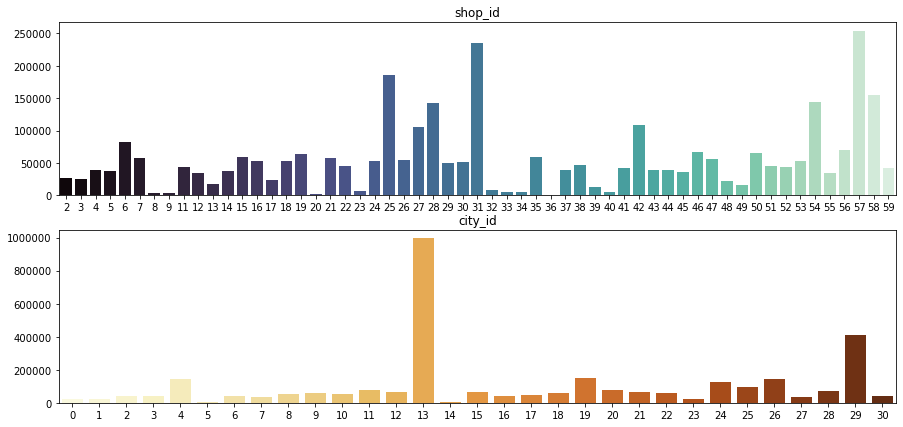

In [31]:
f, axes = plt.subplots(2, 1, figsize=(15,7))
keys,counts = np.unique(df.shop_id, return_counts=True)
sns.barplot(keys, counts,ax=axes[0], palette="mako",errwidth=3).set_title("shop_id")
keys, counts = np.unique(df.city_id, return_counts=True)
sns.barplot(keys, counts,ax = axes[1], palette="YlOrBr").set_title("city_id")
plt.show()

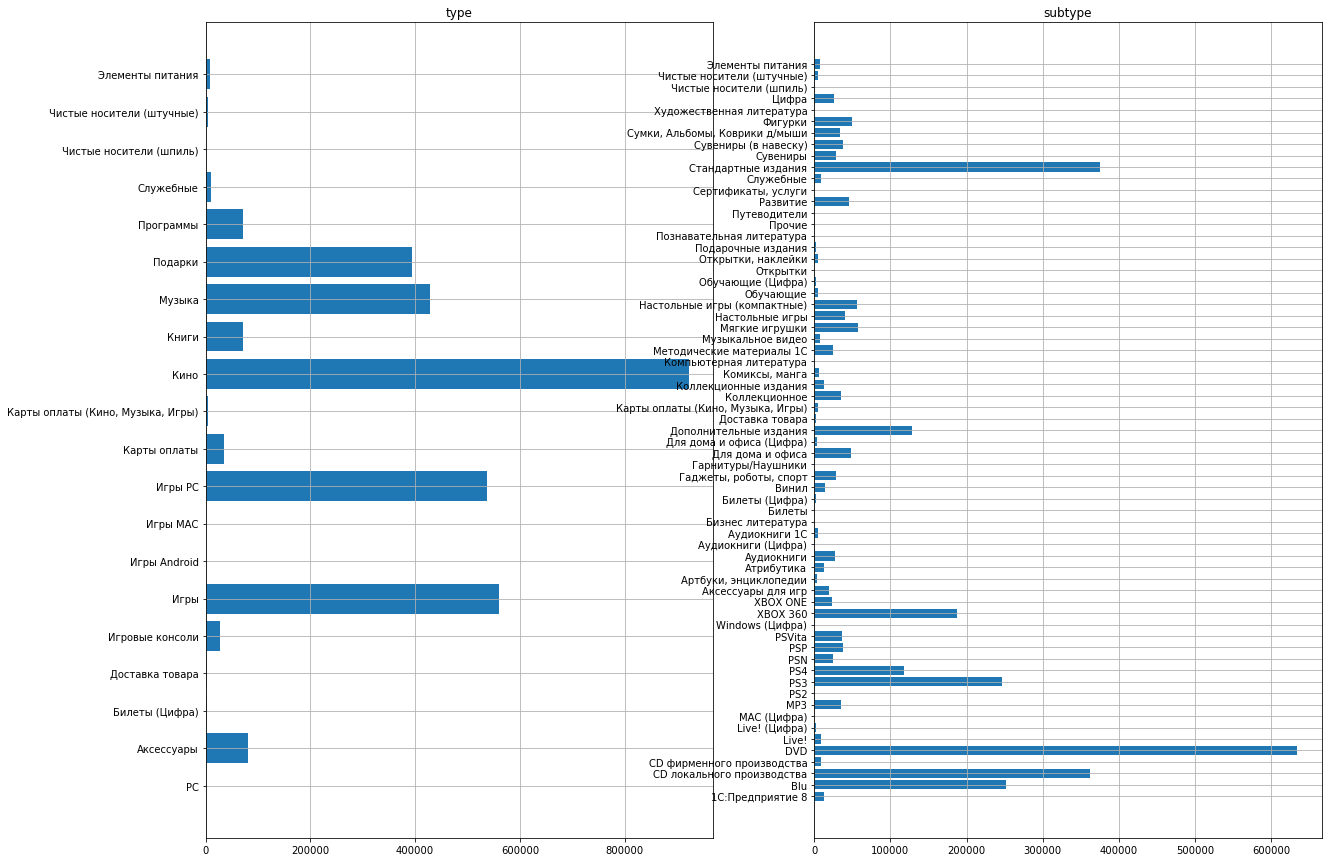

In [32]:
plt.figure(figsize = (20, 15))
plt.subplot(1, 2, 1)
keys, counts = np.unique(df['type'], return_counts=True)
plt.barh(keys,counts)
plt.title('type')
plt.grid()
plt.subplot(1, 2, 2)
keys, counts = np.unique(df['subtype'], return_counts=True)
plt.barh(keys,counts)
plt.title('subtype')
plt.yticks(keys,fontsize = 10)
plt.grid()

Text(0.5, 1.0, 'item_category_id')

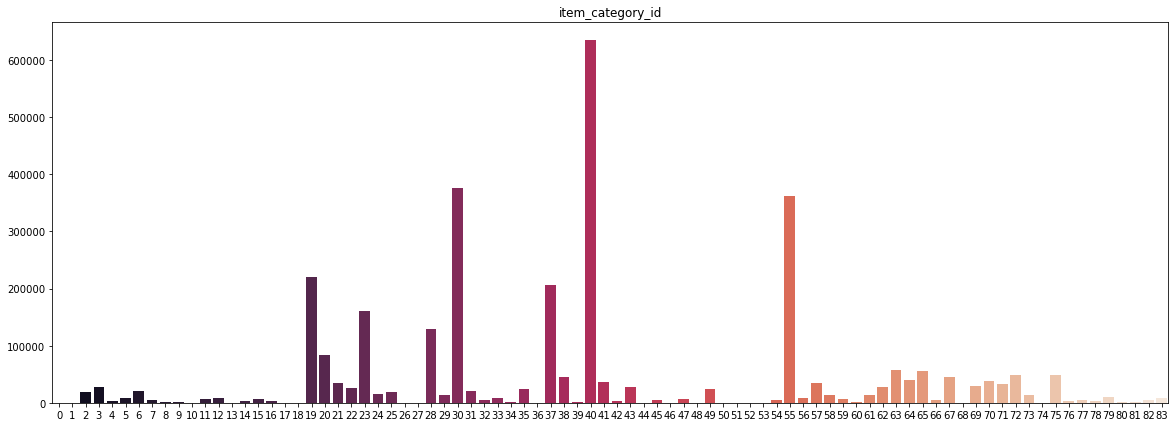

In [33]:
f, axes = plt.subplots(1, 1, figsize=(20,7))
keys,counts = np.unique(df.item_category_id, return_counts=True)
sns.barplot(keys, counts, palette="rocket",errwidth=3).set_title("item_category_id")

In [34]:
# Москва is the most city in the data and Якутск is second.
df.loc[df.city_id.isin([13,29])][['city','item_category_id']]

city  item_category_id
23613    Москва                40
23615    Москва                37
23633    Москва                45
23609    Москва                67
23529    Москва                67
...         ...               ...
3123706  Якутск                40
3123655  Якутск                40
3123656  Якутск                40
3123673  Якутск                83
3123674  Якутск                83

[1405444 rows x 2 columns]

In [35]:
# We also found that item_category_id 30 and 40 are the most and both in the city Москва.
df.loc[df.shop_id.isin([40,30])][['city','shop_id']]

city  shop_id
73226    Москва       30
73224    Москва       30
73247    Москва       30
73221    Москва       30
73220    Москва       30
...         ...      ...
2665248  Москва       30
2665194  Москва       30
2665083  Москва       30
2665080  Москва       30
2665094  Москва       30

[55117 rows x 2 columns]

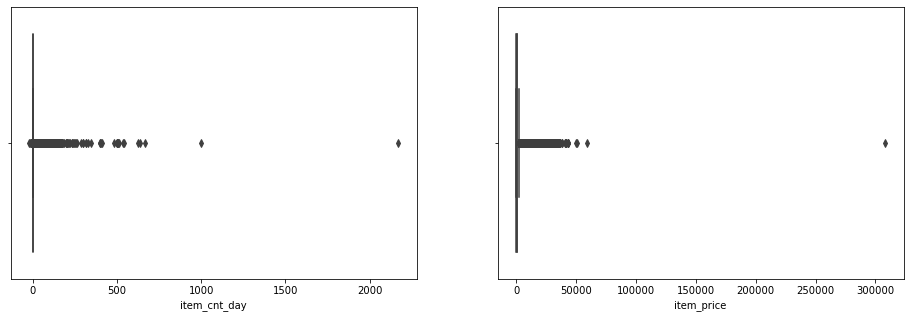

In [36]:
# Boxplot of continous variables which are item_cnt and item_price.
f, axes = plt.subplots(1, 2, figsize=(16,5))
sns.boxplot(df.item_cnt_day,ax=axes[0])
sns.boxplot(df.item_price,ax=axes[1])

In [37]:
### We will replace the price from -1.0 to 1249.0
df[df.item_price<=0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
519973 2013-05-15               4       32     2973        -1.0           1.0   

       item_category_name  item_category_id  \
519973         Игры - PS3                19   

                                        item_name  type subtype  type_code  \
519973  DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   

        subtype_code                   shop_name    city category  city_id  \
519973            10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   

        shop_category  YEAR  month  
519973              8  2013      4

In [38]:
df[(df.item_id==2973) & (df.shop_id==32)]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
75795  2013-01-15               0       32     2973      2499.0           3.0   
75794  2013-01-17               0       32     2973      2499.0           1.0   
75793  2013-01-18               0       32     2973      2499.0           1.0   
75792  2013-01-21               0       32     2973      2499.0           1.0   
75791  2013-01-22               0       32     2973      2499.0           1.0   
75790  2013-01-25               0       32     2973      2499.0           1.0   
75789  2013-01-29               0       32     2973      2499.0           1.0   
205166 2013-02-05               1       32     2973      2499.0           1.0   
205167 2013-02-14               1       32     2973      2499.0           1.0   
519974 2013-05-06               4       32     2973      2499.0           1.0   
519973 2013-05-15               4       32     2973        -1.0           1.0   
519972 2013-05-23               4       32     2973      1249.0           1.0   
597709 2013-06-05               5       32     2973      1249.5           1.0   

       item_category_name  item_category_id  \
75795          Игры - PS3                19   
75794          Игры - PS3                19   
75793          Игры - PS3                19   
75792          Игры - PS3                19   
75791          Игры - PS3                19   
75790          Игры - PS3                19   
75789          Игры - PS3                19   
205166         Игры - PS3                19   
205167         Игры - PS3                19   
519974         Игры - PS3                19   
519973         Игры - PS3                19   
519972         Игры - PS3                19   
597709         Игры - PS3                19   

                                        item_name  type subtype  type_code  \
75795   DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
75794   DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
75793   DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
75792   DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
75791   DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
75790   DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
75789   DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
205166  DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
205167  DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
519974  DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
519973  DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
519972  DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   
597709  DmC Devil May Cry [PS3, русские субтитры]  Игры     PS3          5   

        subtype_code                   shop_name    city category  city_id  \
75795             10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
75794             10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
75793             10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
75792             10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
75791             10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
75790             10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
75789             10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
205166            10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
205167            10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
519974            10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
519973            10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
519972            10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   
597709            10  Москва ТЦ "Серебряный Дом"  Москва       ТЦ       13   

        shop_category  YEAR  mont

In [39]:
df[df.item_price>100000]

date  date_block_num  shop_id  item_id  item_price  \
1253430 2013-12-13              11       12     6066    307980.0   

         item_cnt_day            item_category_name  item_category_id  \
1253430           1.0  Программы - Для дома и офиса                75   

                    item_name       type           subtype  type_code  \
1253430  Radmin 3  - 522 лиц.  Программы  Для дома и офиса         15   

         subtype_code            shop_name              city category  \
1253430            30  Интернет-магазин ЧС  Интернет-магазин       ЧС   

         city_id  shop_category  YEAR  month  
1253430        7             10  2013     11

In [40]:
%%time
# calculate the monthly sales
ts = df[["date", "item_cnt_day"]].set_index("date").resample("M").sum() #resamble ("M") significa que quieres agrupar por mes (Y=anuales, W=Semanales...)
ts.head() 

CPU times: user 111 ms, sys: 21.2 ms, total: 132 ms
Wall time: 141 ms


item_cnt_day
date                    
2013-01-31      140939.0
2013-02-28      138607.0
2013-03-31      158518.0
2013-04-30      116270.0
2013-05-31      115194.0

# Monthly sales 
### We found that monthly sales exists seasonality and trend.

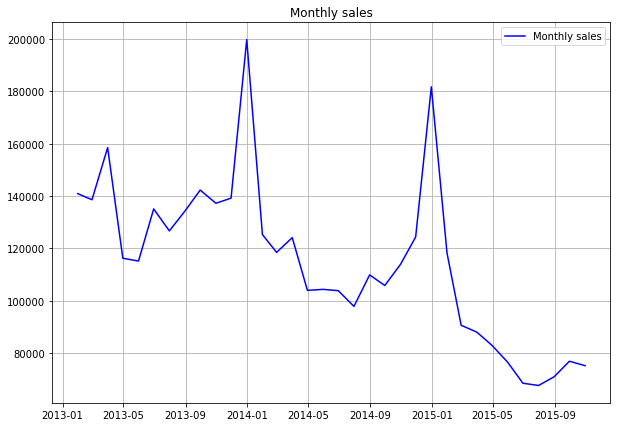

In [41]:
plt.figure(figsize = (10, 7))
plt.plot(ts, color = "blue", label = "Monthly sales")
plt.title("Monthly sales")
plt.grid()
plt.legend();

### We use multiplicative model to decomposed the series.
### There were high sales volumes in december and the trend went low during the time.

<Figure size 800x560 with 0 Axes>

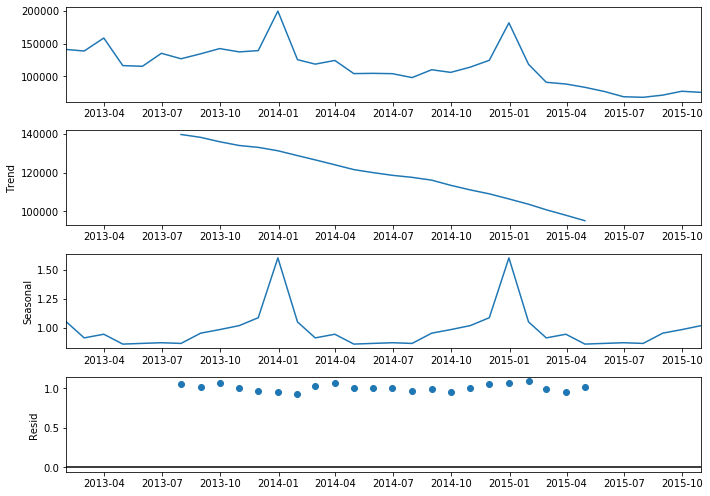

In [42]:
rcParams['figure.figsize'] = 10, 7
plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
series = ts
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

# Augmented Dickey–Fuller test (ADF Test)
### The series is stationary which means series have constant mean and variance.

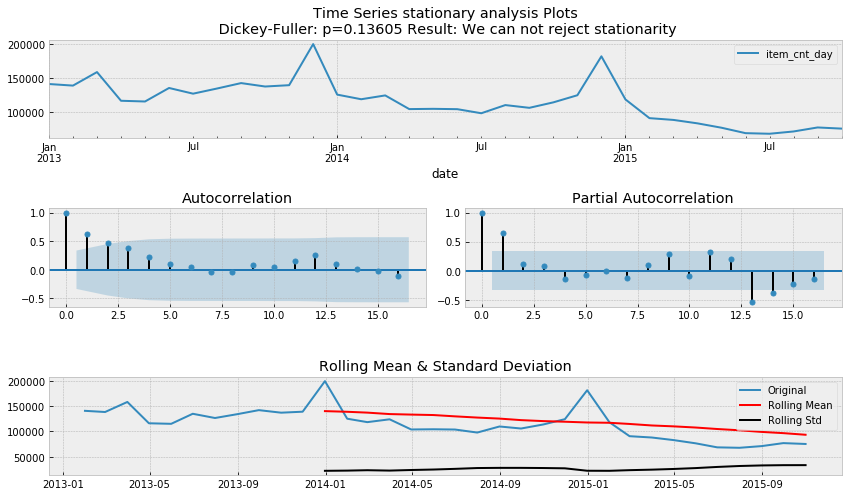

In [43]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):


    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        mean_std_ax = plt.subplot2grid(layout, (2,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value<=0.05 else "We can not reject stationarity"
        ts_ax.set_title('Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value,hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        rolmean = y.rolling(window=12).mean()
        rolstd = y.rolling(window=12).std()

        #Plot rolling statistics:
        orig = plt.plot(y,label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        
        
tsplot(ts)

# Marginal effect

In [44]:
russian_holidays_start = [
datetime.datetime(2013, 1, 1),
datetime.datetime(2013, 2, 23),
datetime.datetime(2013, 3, 8),
datetime.datetime(2013, 5, 1),
datetime.datetime(2013, 5, 9),
datetime.datetime(2013, 6, 12),
datetime.datetime(2013, 11, 4),

datetime.datetime(2014, 1, 1),
datetime.datetime(2014, 2, 23),
datetime.datetime(2014, 3, 8),
datetime.datetime(2014, 5, 1),
datetime.datetime(2014, 5, 9),
datetime.datetime(2014, 6, 12),
datetime.datetime(2014, 11, 4),

datetime.datetime(2015, 1, 1),
datetime.datetime(2015, 2, 23),
datetime.datetime(2015, 3, 8),
datetime.datetime(2015, 5, 1),
datetime.datetime(2015, 5, 9),
datetime.datetime(2015, 6, 12),
datetime.datetime(2015, 11, 4)
]

In [45]:
russian_holidays_end = [
datetime.datetime(2013, 1, 8),
datetime.datetime(2013, 2, 23),
datetime.datetime(2013, 3, 8),
datetime.datetime(2013, 5, 1),
datetime.datetime(2013, 5, 9),
datetime.datetime(2013, 6, 12),
datetime.datetime(2013, 11, 4),

datetime.datetime(2014, 1, 8),
datetime.datetime(2014, 2, 23),
datetime.datetime(2014, 3, 8),
datetime.datetime(2014, 5, 1),
datetime.datetime(2014, 5, 9),
datetime.datetime(2014, 6, 12),
datetime.datetime(2014, 11, 4),

datetime.datetime(2015, 1, 8),
datetime.datetime(2015, 2, 23),
datetime.datetime(2015, 3, 8),
datetime.datetime(2015, 5, 1),
datetime.datetime(2015, 5, 9),
datetime.datetime(2015, 6, 12),
datetime.datetime(2015, 11, 4)
]

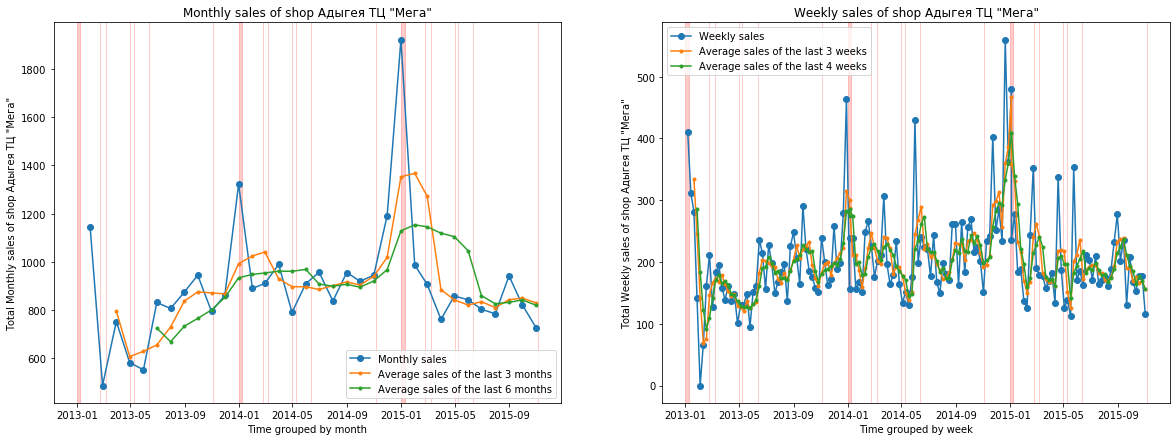

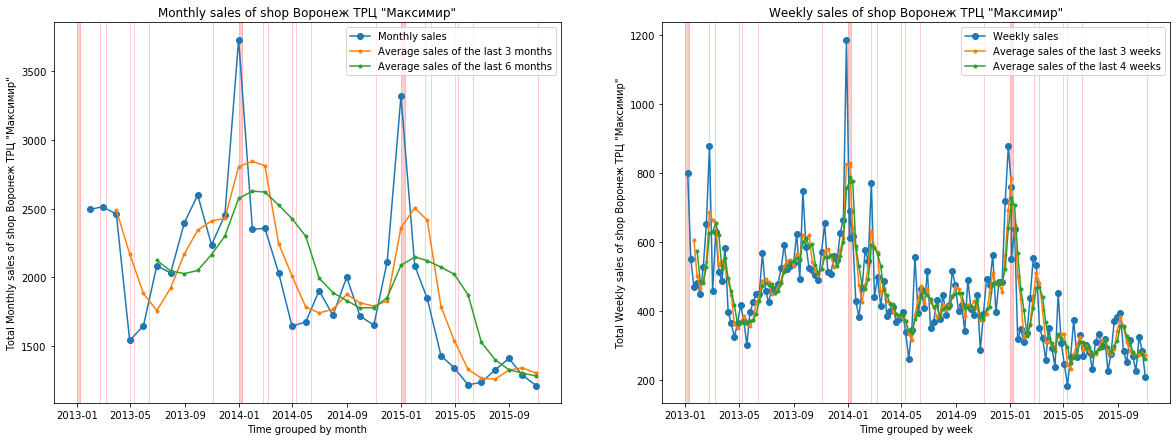

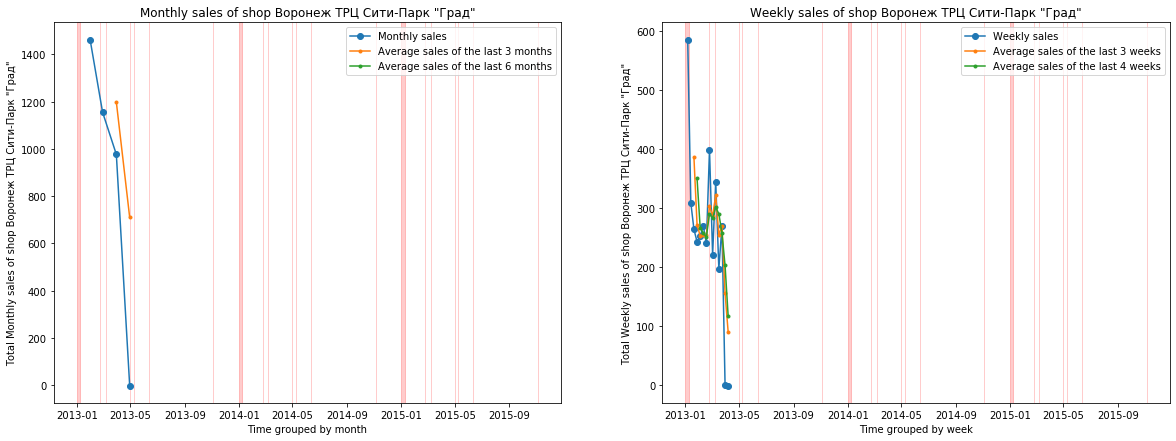

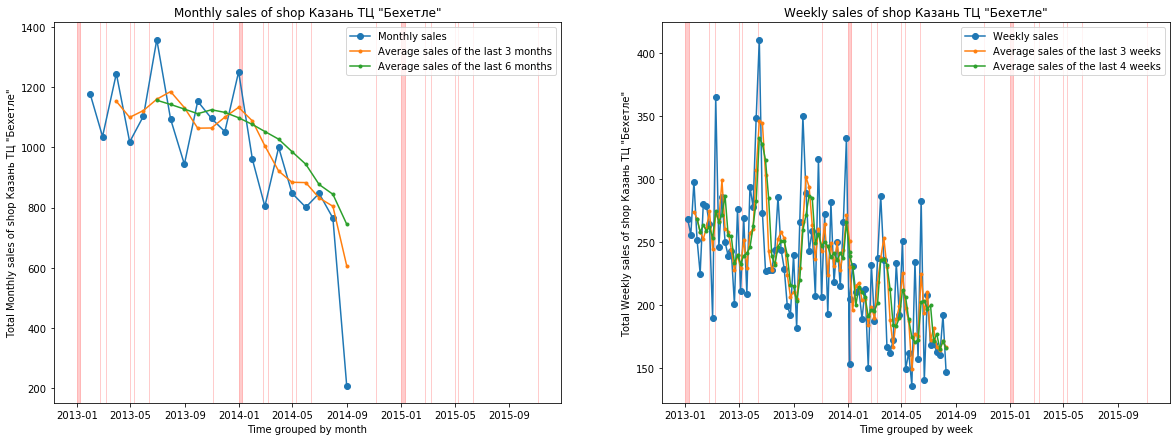

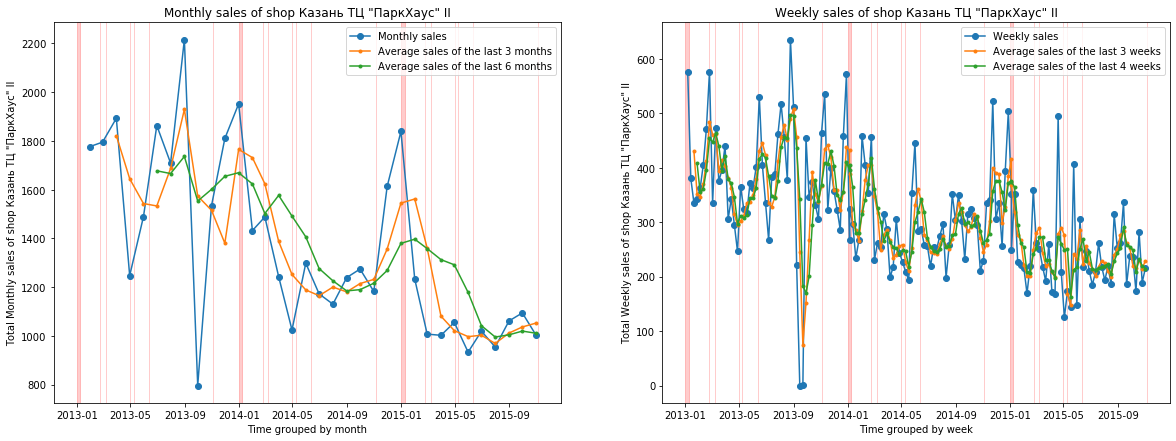

CPU times: user 7.54 s, sys: 525 ms, total: 8.06 s
Wall time: 5.23 s


In [46]:
%%time
for iterable in sorted(list(df["shop_name"].unique())[:5]):

    # create the size of the figure
    plt.figure(figsize = (20, 7))

    # create the subplot for Monthly sales of the each shop
    plt.subplot(1, 2, 1)
    
    # calculate the Monthly sales of each shop
    short_df = df[df["shop_name"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("M")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3M"] = short_df["item_cnt_day"].rolling(window = 3).mean()
    short_df["MA4M"] = short_df["item_cnt_day"].rolling(window = 4).mean()
    short_df["MA6M"] = short_df["item_cnt_day"].rolling(window = 6).mean()
    # assing the data to plot
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    
    average_3_months = short_df["MA3M"]
    average_4_months = short_df["MA4M"]
    average_6_months = short_df["MA6M"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Monthly sales")
    
    plt.plot(dates, average_3_months, '.-', label = "Average sales of the last 3 months")
    plt.plot(dates, average_6_months, '.-', label = "Average sales of the last 6 months")
    # get current axis and plot the areas
    ax = plt.gca()
    alpha = 0.2
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')    
       
    # add title and show legend    
    plt.title('Monthly sales of shop {}'.format(iterable))
    plt.ylabel('Total Monthly sales of shop {}'.format(iterable))
    plt.xlabel("Time grouped by month")
    plt.legend()
    # Weekly sales
    #######################################################################################
    
    plt.subplot(1, 2, 2)
    
      # calculate the Weekly sales of each shop
    short_df = df[df["shop_name"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("W")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3W"] = short_df["item_cnt_day"].rolling(window=3).mean()
    short_df["MA4W"] = short_df["item_cnt_day"].rolling(window=4).mean()
    short_df["MA6W"] = short_df["item_cnt_day"].rolling(window=5).mean()
    
    # assing the data to plot
    
    # general sales
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    average_3_weeks = short_df["MA3W"]
    average_4_weeks = short_df["MA4W"]
    average_6_weeks = short_df["MA6W"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Weekly sales")
    plt.plot(dates, average_3_weeks, '.-', label = "Average sales of the last 3 weeks")
    plt.plot(dates, average_4_weeks, '.-', label = "Average sales of the last 4 weeks")
    
    # get current axis and plot the areas
    ax = plt.gca()
    
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')
    
    # add title and show legend
    plt.title('Weekly sales of shop {}'.format(iterable))
    plt.ylabel('Total Weekly sales of shop {}'.format(iterable))
    plt.xlabel("Time grouped by week")
    plt.legend()
    
    # general sales
    plt.show()

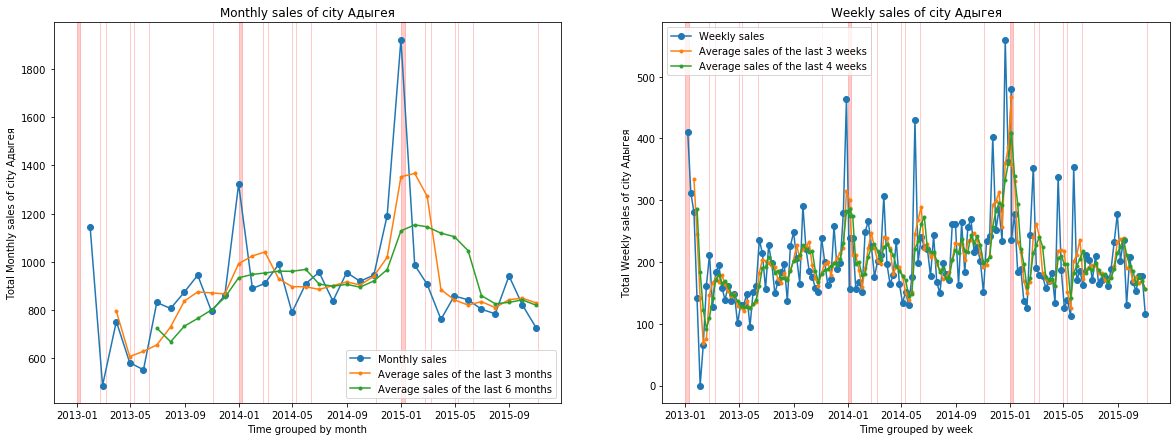

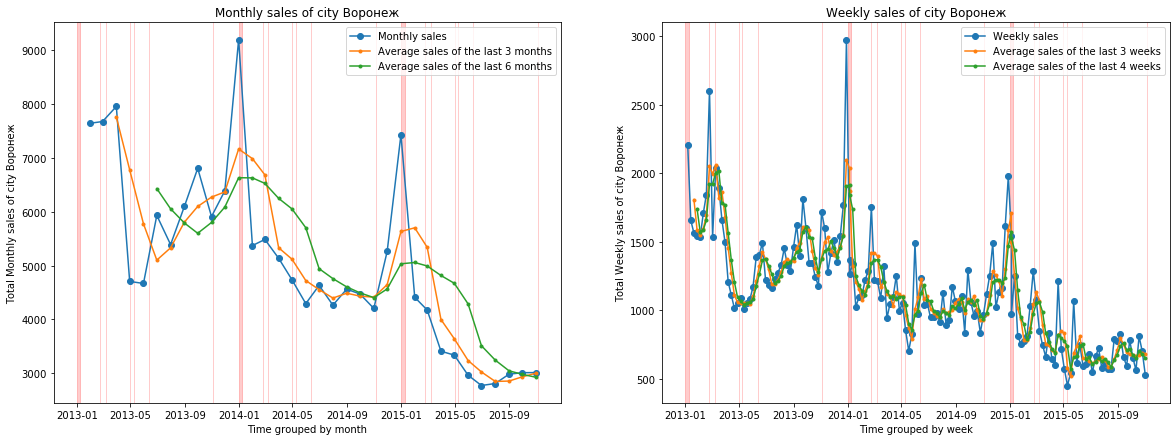

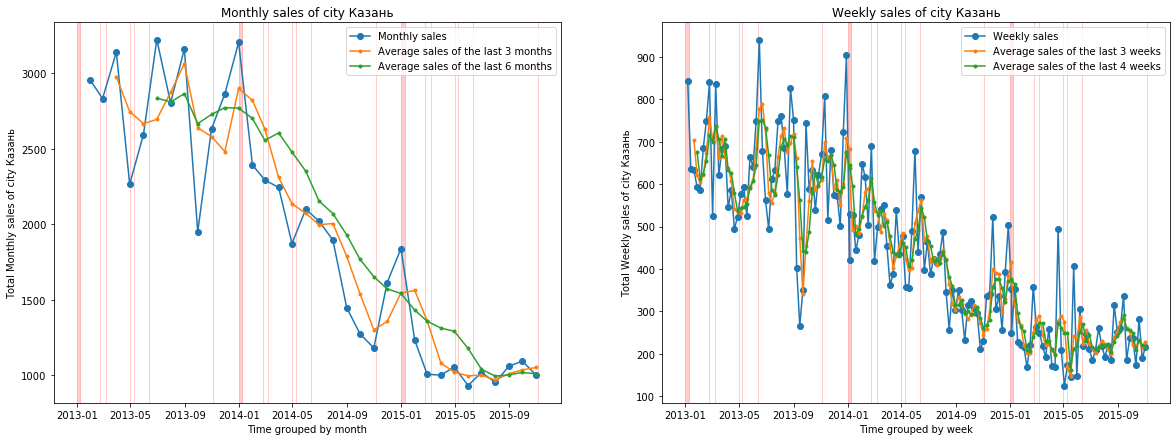

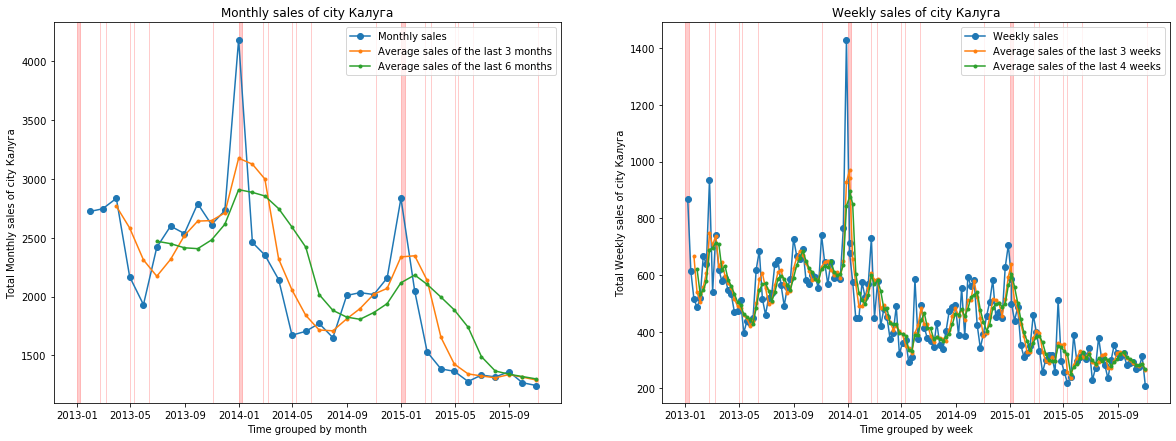

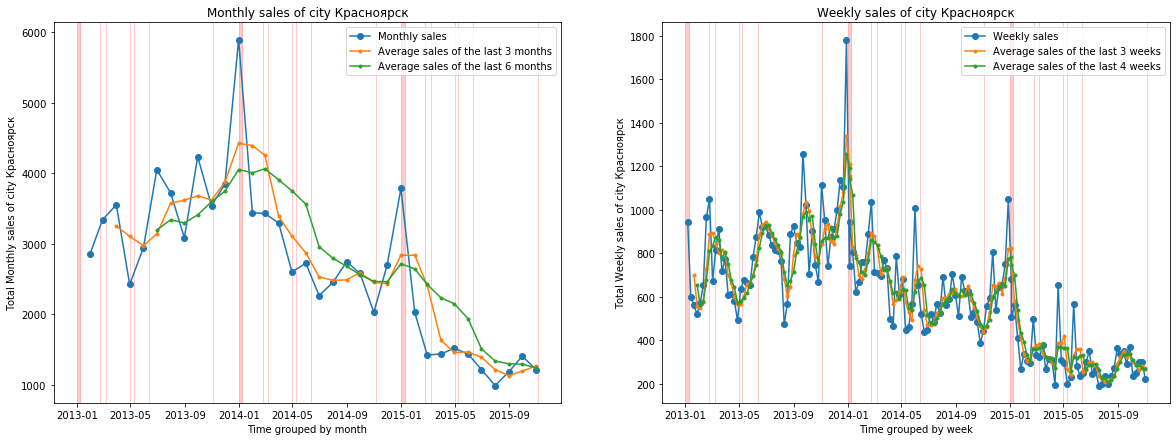

CPU times: user 7.51 s, sys: 537 ms, total: 8.05 s
Wall time: 5.21 s


In [47]:
%%time
for iterable in sorted(list(df["city"].unique())[:5]):

    # create the size of the figure
    plt.figure(figsize = (20, 7))

    # create the subplot for Monthly sales of the each shop
    plt.subplot(1, 2, 1)
    
    # calculate the Monthly sales of each shop
    short_df = df[df["city"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("M")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3M"] = short_df["item_cnt_day"].rolling(window = 3).mean()
    short_df["MA4M"] = short_df["item_cnt_day"].rolling(window = 4).mean()
    short_df["MA6M"] = short_df["item_cnt_day"].rolling(window = 6).mean()
    # assing the data to plot
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    
    average_3_months = short_df["MA3M"]
    average_4_months = short_df["MA4M"]
    average_6_months = short_df["MA6M"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Monthly sales")
    
    plt.plot(dates, average_3_months, '.-', label = "Average sales of the last 3 months")
    plt.plot(dates, average_6_months, '.-', label = "Average sales of the last 6 months")
    # get current axis and plot the areas
    ax = plt.gca()
    alpha = 0.2
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')    
       
    # add title and show legend    
    plt.title('Monthly sales of city {}'.format(iterable))
    plt.ylabel('Total Monthly sales of city {}'.format(iterable))
    plt.xlabel("Time grouped by month")
    plt.legend()
    # Weekly sales
    #######################################################################################
    
    plt.subplot(1, 2, 2)
    
      # calculate the Weekly sales of each shop
    short_df = df[df["city"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("W")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3W"] = short_df["item_cnt_day"].rolling(window=3).mean()
    short_df["MA4W"] = short_df["item_cnt_day"].rolling(window=4).mean()
    short_df["MA6W"] = short_df["item_cnt_day"].rolling(window=5).mean()
    
    # assing the data to plot
    
    # general sales
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    average_3_weeks = short_df["MA3W"]
    average_4_weeks = short_df["MA4W"]
    average_6_weeks = short_df["MA6W"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Weekly sales")
    plt.plot(dates, average_3_weeks, '.-', label = "Average sales of the last 3 weeks")
    plt.plot(dates, average_4_weeks, '.-', label = "Average sales of the last 4 weeks")
    
    # get current axis and plot the areas
    ax = plt.gca()
    
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')
    
    # add title and show legend
    plt.title('Weekly sales of city {}'.format(iterable))
    plt.ylabel('Total Weekly sales of city {}'.format(iterable))
    plt.xlabel("Time grouped by week")
    plt.legend()
    
    # general sales
    plt.show()

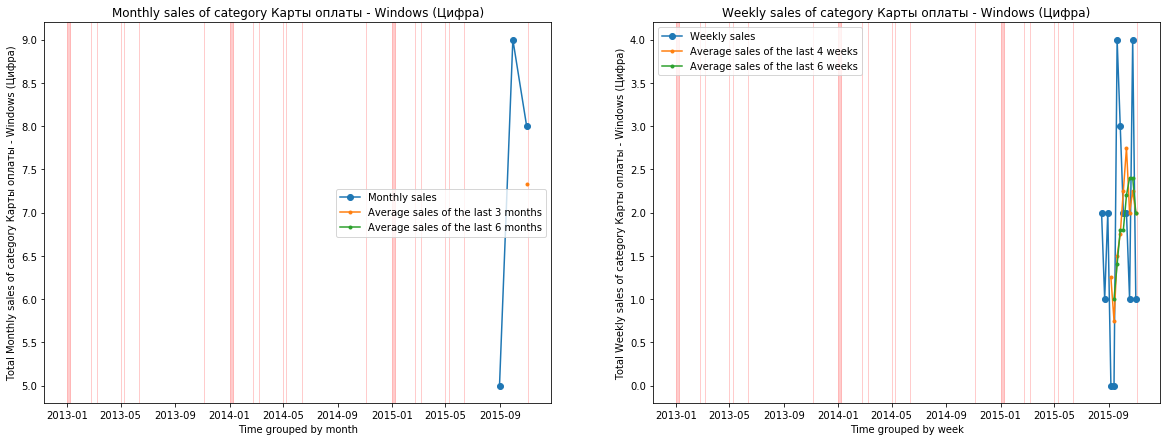

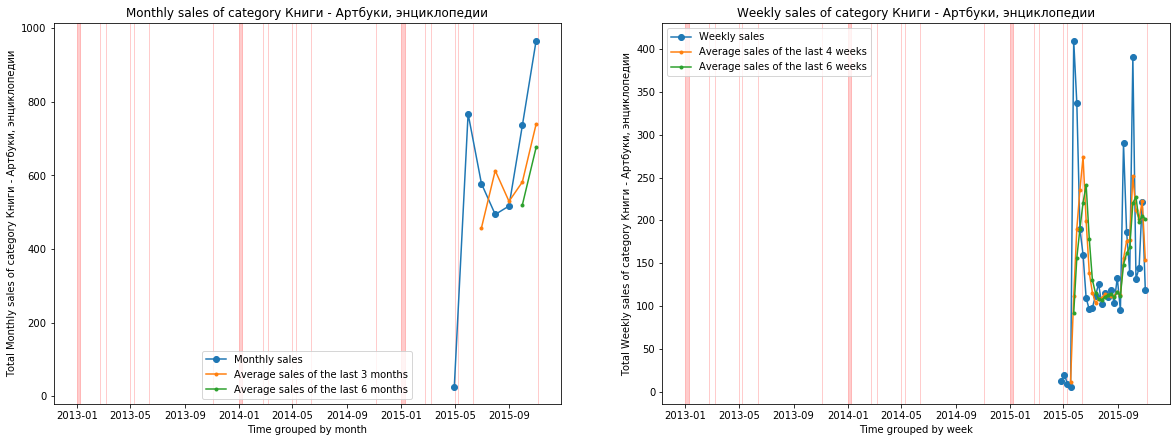

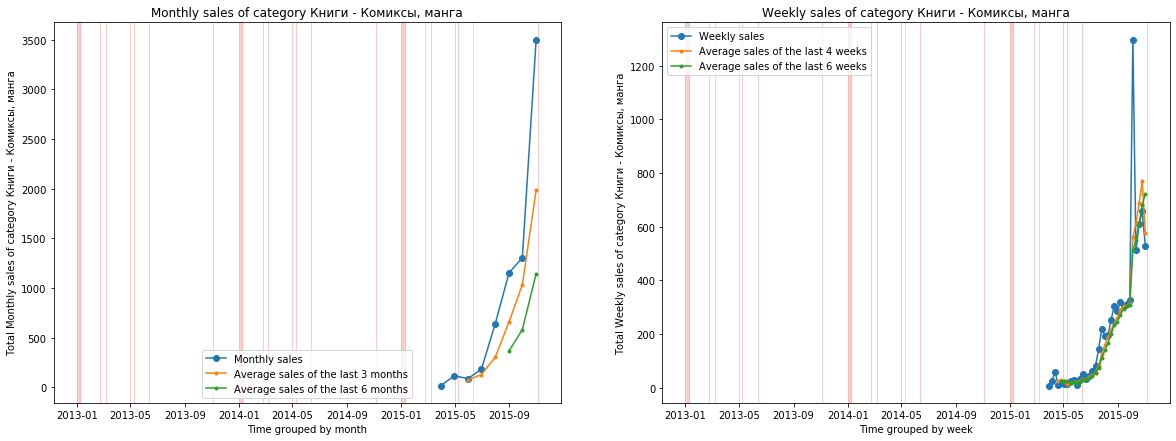

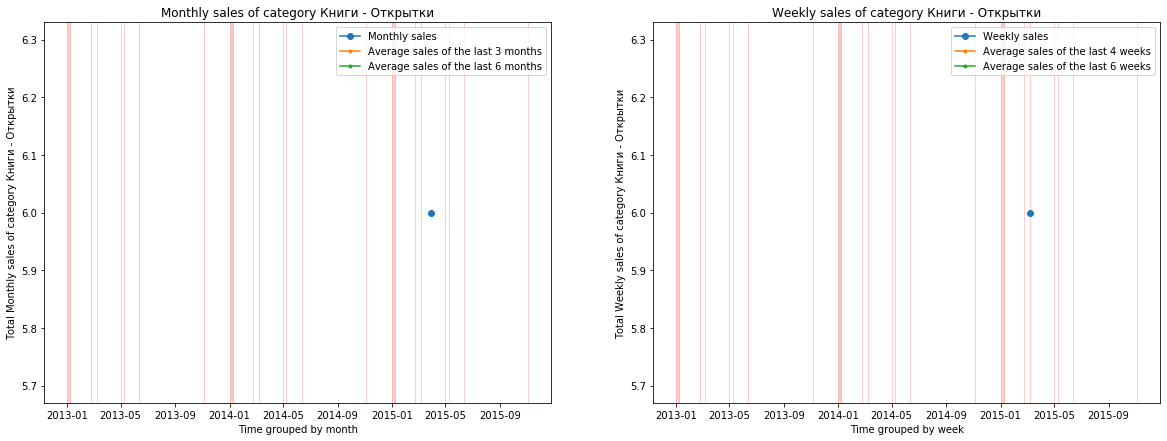

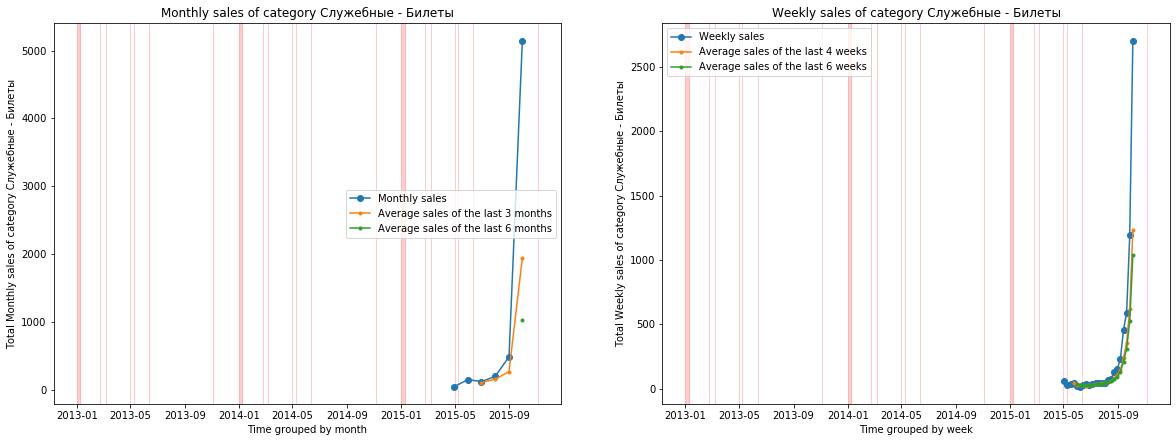

CPU times: user 7.22 s, sys: 478 ms, total: 7.7 s
Wall time: 4.89 s


In [48]:
%%time
for iterable in sorted(list(df["item_category_name"].unique())[-5:]):

    # create the size of the figure
    plt.figure(figsize = (20, 7))

    # create the subplot for Monthly sales of the each shop
    plt.subplot(1, 2, 1)
    
    # calculate the Monthly sales of each shop
    short_df = df[df["item_category_name"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("M")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3M"] = short_df["item_cnt_day"].rolling(window = 3).mean()
    short_df["MA4M"] = short_df["item_cnt_day"].rolling(window = 4).mean()
    short_df["MA6M"] = short_df["item_cnt_day"].rolling(window = 6).mean()
    # assing the data to plot
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    
    average_3_months = short_df["MA3M"]
    average_4_months = short_df["MA4M"]
    average_6_months = short_df["MA6M"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Monthly sales")
    
    plt.plot(dates, average_3_months, '.-', label = "Average sales of the last 3 months")
    plt.plot(dates, average_6_months, '.-', label = "Average sales of the last 6 months")
    # get current axis and plot the areas
    ax = plt.gca()
    alpha = 0.2
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')    
       
    # add title and show legend    
    plt.title('Monthly sales of category {}'.format(iterable))
    plt.ylabel('Total Monthly sales of category {}'.format(iterable))
    plt.xlabel("Time grouped by month")
    plt.legend()
    # Weekly sales
    #######################################################################################
    
    plt.subplot(1, 2, 2)
    
      # calculate the Weekly sales of each shop
    short_df = df[df["item_category_name"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("W")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3W"] = short_df["item_cnt_day"].rolling(window=3).mean()
    short_df["MA4W"] = short_df["item_cnt_day"].rolling(window=4).mean()
    short_df["MA6W"] = short_df["item_cnt_day"].rolling(window=5).mean()
    
    # assing the data to plot
    
    # general sales
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    average_3_weeks = short_df["MA3W"]
    average_4_weeks = short_df["MA4W"]
    average_6_weeks = short_df["MA6W"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Weekly sales")
    plt.plot(dates, average_4_weeks, '.-', label = "Average sales of the last 4 weeks")
    plt.plot(dates, average_6_weeks, '.-', label = "Average sales of the last 6 weeks")
    
    # get current axis and plot the areas
    ax = plt.gca()
    
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')
    
    # add title and show legend
    plt.title('Weekly sales of category {}'.format(iterable))
    plt.ylabel('Total Weekly sales of category {}'.format(iterable))
    plt.xlabel("Time grouped by week")
    plt.legend()
    
    # general sales
    plt.show()

# Calendar heatmaps
### We fixed the year to see the relation between the item_cnt_day and the days.

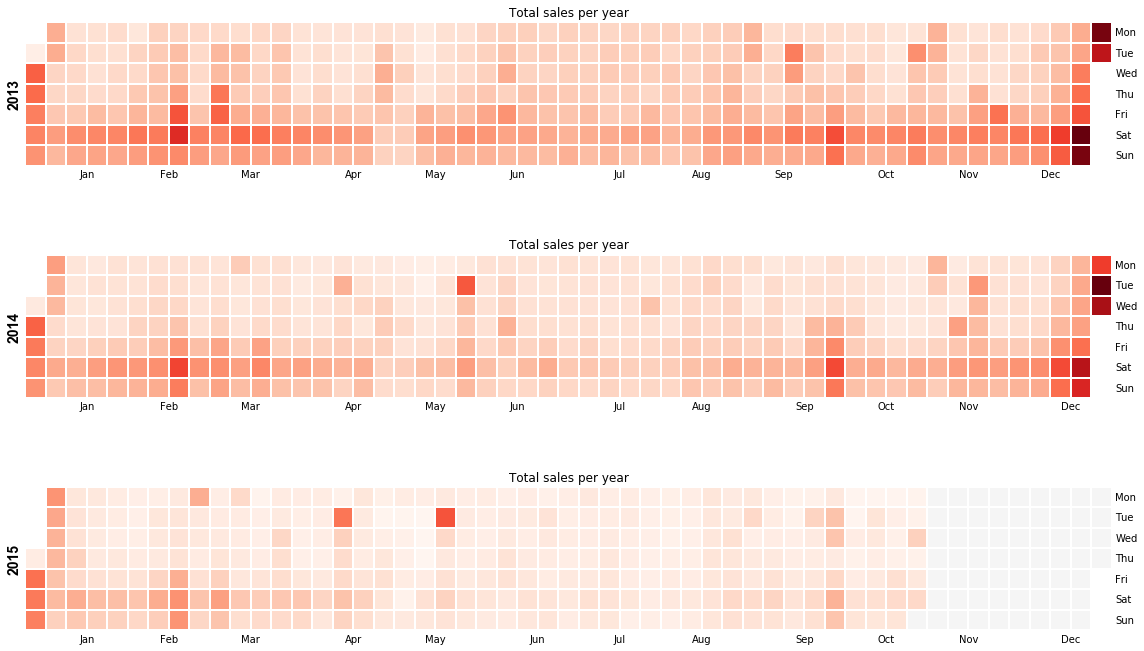

In [49]:
# calendar heatmaps are really useful to see the overall activity for a certain period of time per day and per month.
# let's build one using python.
# we will be using the calmap package for this, because it makes it extremenly easy to plot this data
# select the columns
df_calendar = df[["date", "item_cnt_day"]]

# set date as index and resample
df_calendar.set_index("date", inplace = True)
# notice that this time, we don't convert it to_frame()
# df_calendar is a pandas series
# THIS IS IMPORTANT since calmap expects a series
# with a datetime index and the values to plot
df_calendar = df_calendar.resample("D")["item_cnt_day"].sum()

# ----------------------------------------------------------------------------------------------------
# plot the data using calmap
calmap.calendarplot(df_calendar, # pass the series
                    fig_kws = {'figsize': (16,10)}, 
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

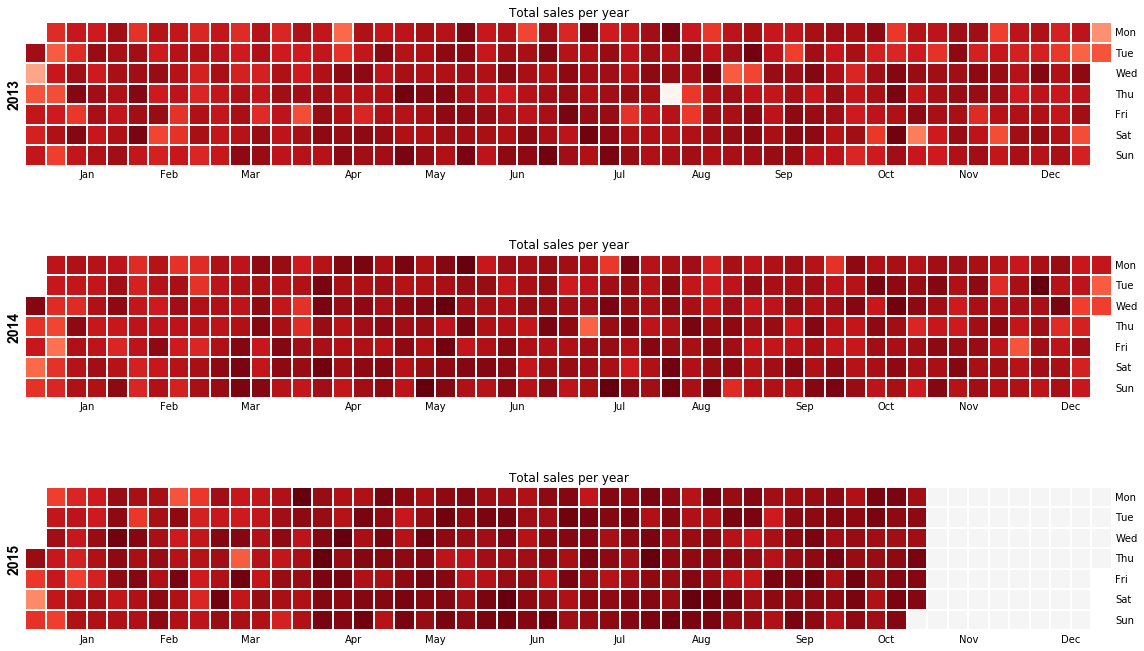

In [50]:
# We only keep the negative cnt_day to see whether exist pattern, but it seems random.
# select the columns
df_calendar = df.loc[df.item_cnt_day<0][["date", "item_cnt_day"]].copy()
df_calendar['item_cnt_day'] * -1
# set date as index and resample
df_calendar.set_index("date", inplace = True)
# notice that this time, we don't convert it to_frame()
# df_calendar is a pandas series
# THIS IS IMPORTANT since calmap expects a series
# with a datetime index and the values to plot
df_calendar = df_calendar.resample("D")["item_cnt_day"].sum()

# ----------------------------------------------------------------------------------------------------
# plot the data using calmap
calmap.calendarplot(df_calendar, # pass the series
                    fig_kws = {'figsize': (16,10)}, 
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

## City information
### Fix the years (2013, 2014, 2015) and sum item_cnt_day group by city.

In [51]:
def heatmap_year(y,variables):    
    # y : year
    # variables : variables u want to focus
    #variables = ['item_cnt_day']
    #variables.append(var)
    short_df = df[df["YEAR"] == y][variables]

    # groupby by city and sum all the sales
    short_df = short_df.groupby(variables[1:])[variables[0]].sum().to_frame()

    # sort the values in the smaller df inplace
    short_df.sort_values(variables[0], ascending = False, inplace = True)
    my_values = short_df[variables[0]]
    my_pct = short_df[variables[0]]/short_df[variables[0]].sum()
    labels = ['{} - Sales :{}k \n {}% of total'.format(city, sales/1000, round(pct, 2)*100) for city, sales, pct in zip(short_df.index, my_values, my_pct)]
    plt.figure(figsize = (30, 8))
    squarify.plot(sizes = my_values, label = labels,  alpha = 0.8)
    #plt.title("Sales by and their % over total sales in"+str(y),fontsize = 20, fontweight = "bold")  
    plt.title("Sales by variables and their % over total sales in "+str(y),fontsize = 20, fontweight = "bold")
    plt.axis('off')
    plt.tight_layout()

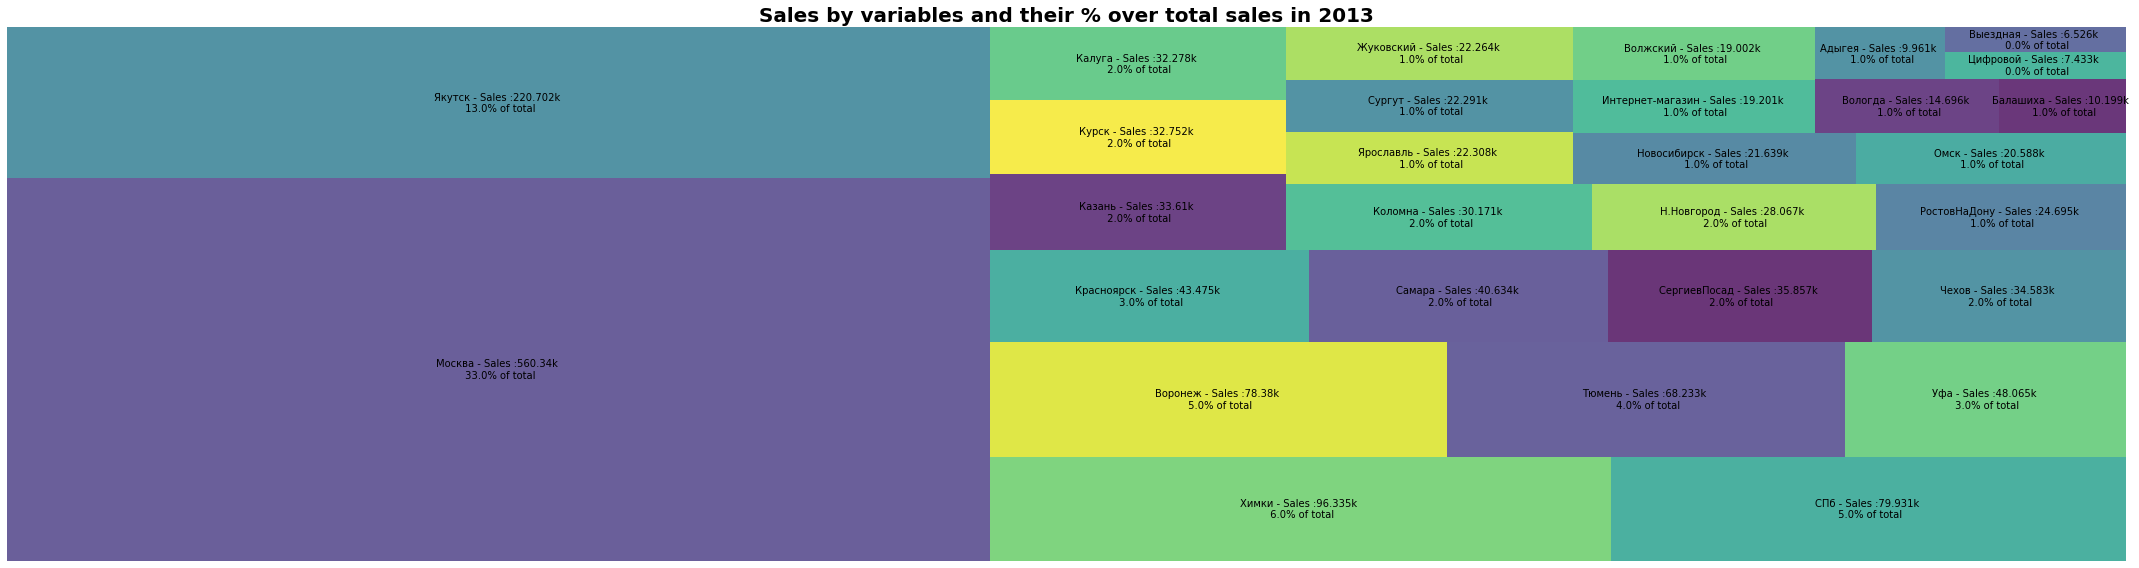

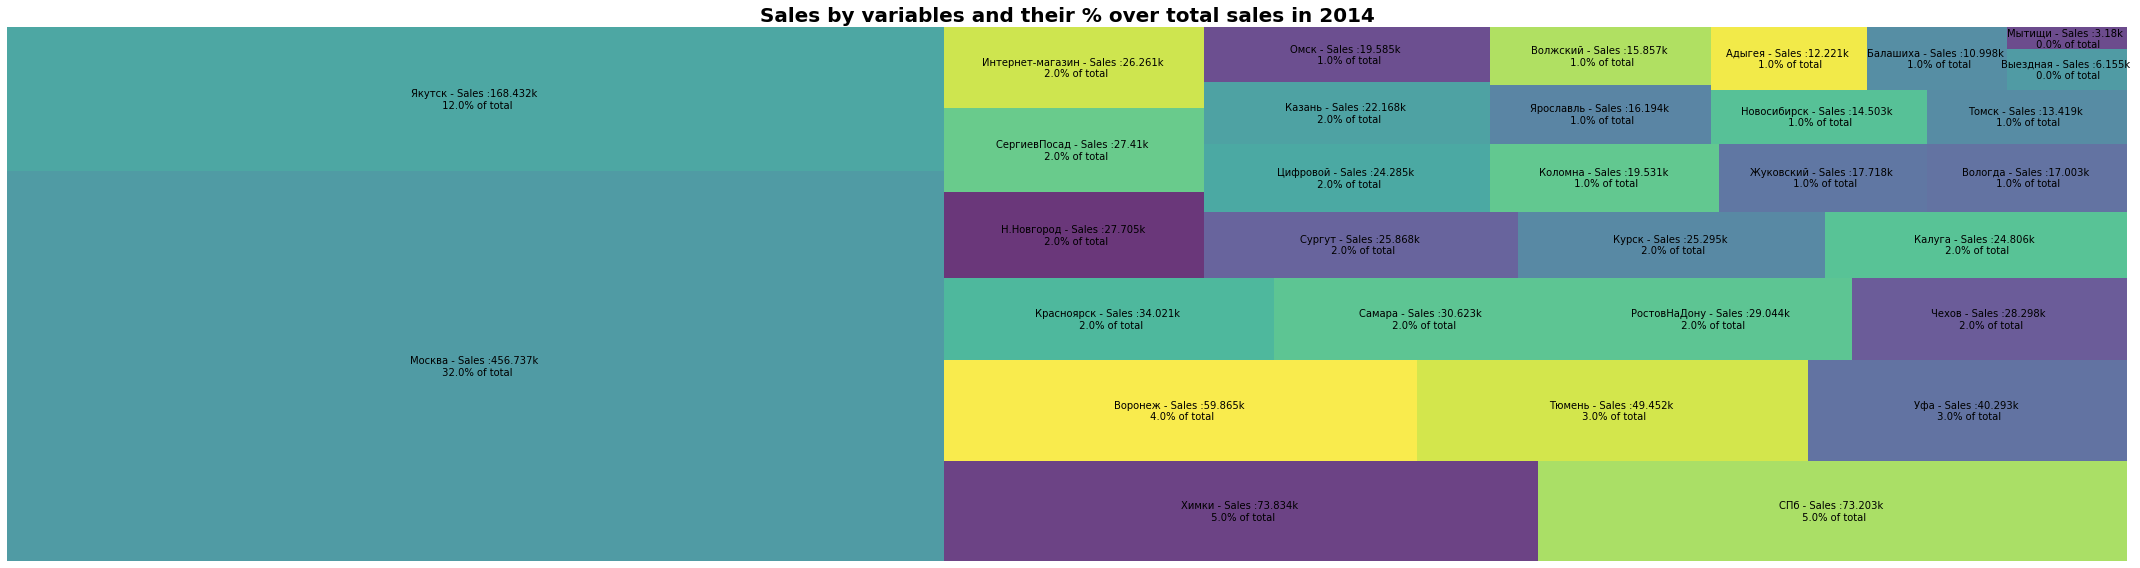

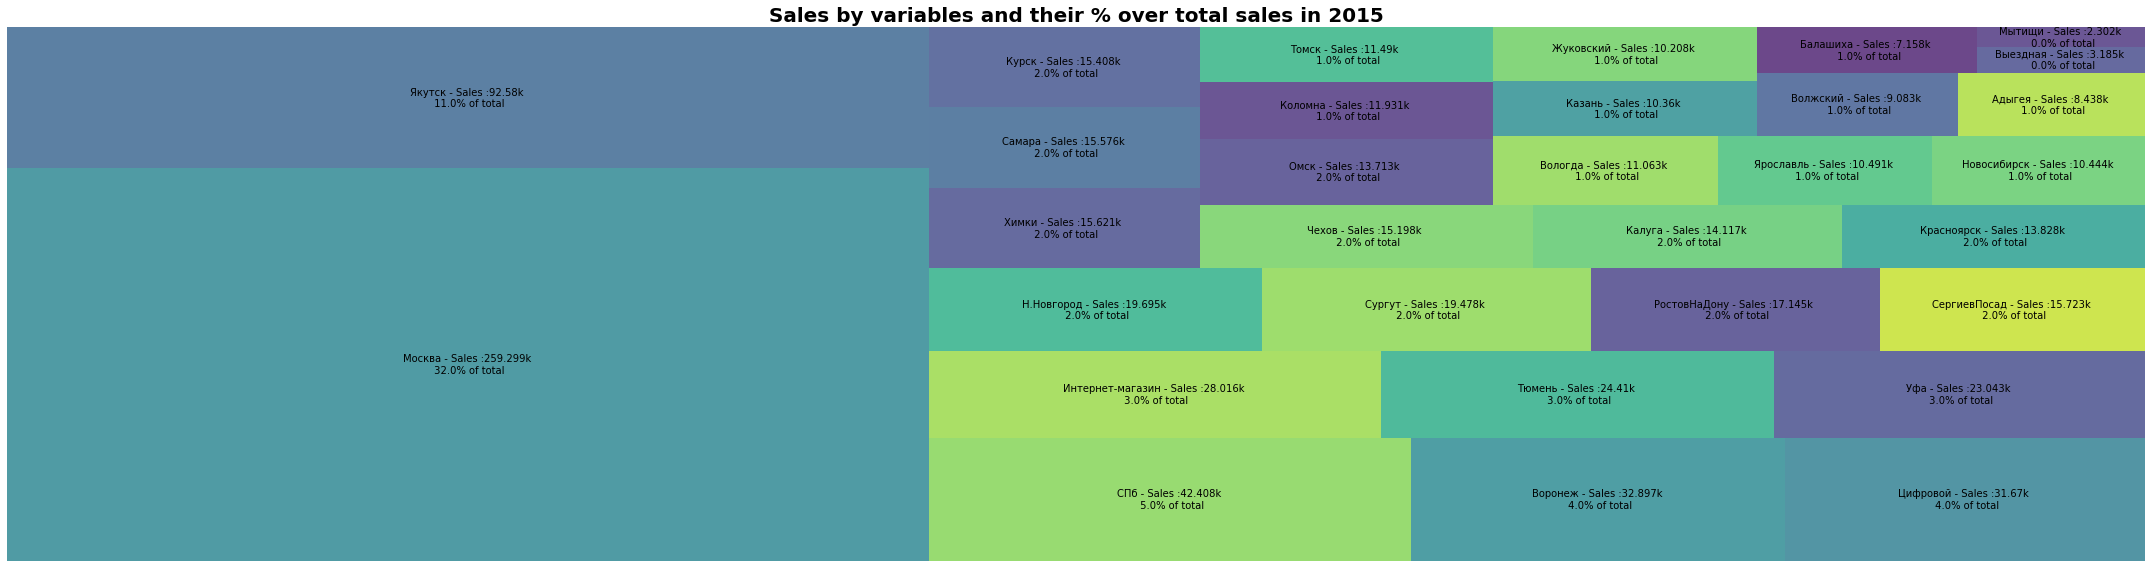

In [52]:
#df["YEAR"] = df["date"].dt.year
#df['month'] = df["date_block_num"] % 12
for y in [2013,2014,2015]:
    heatmap_year(y,['item_cnt_day','city'])

## Shop effect
### Fix the years (2013, 2014, 2015) and sum item_cnt_day group by shop.

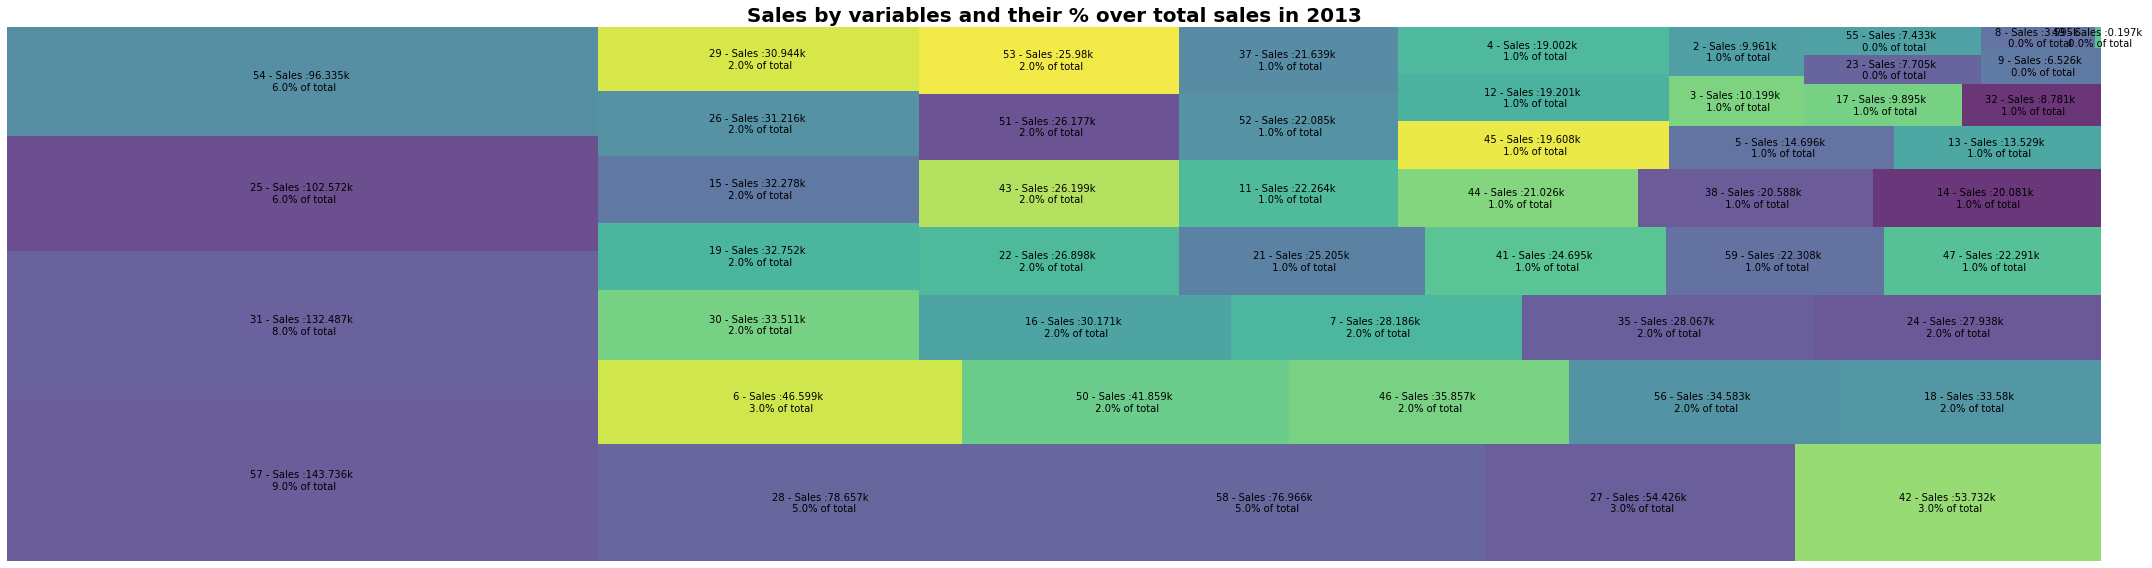

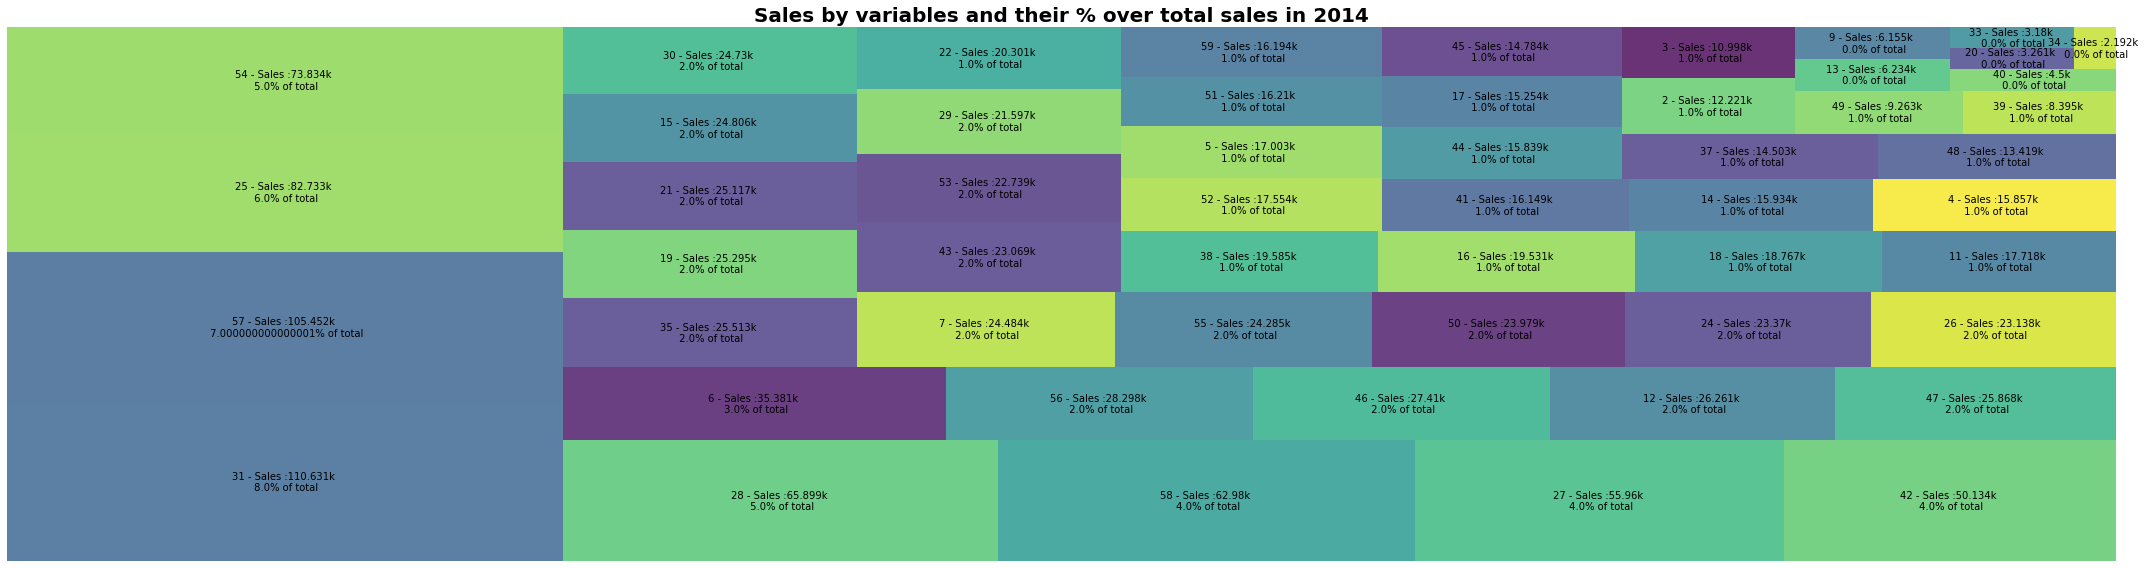

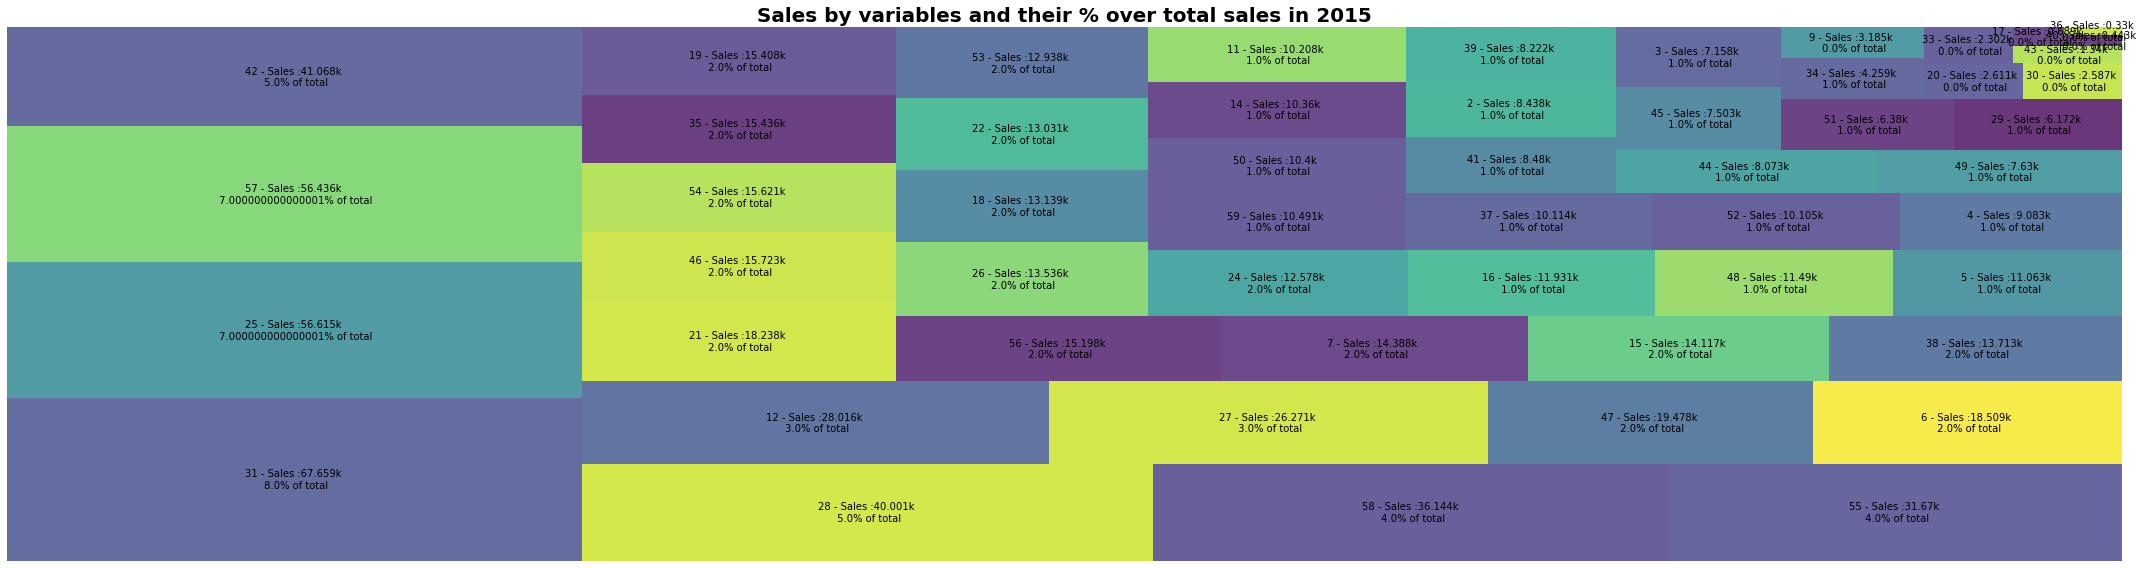

In [53]:
for y in [2013,2014,2015]:
    heatmap_year(y,['item_cnt_day','shop_id'])

# Type effect
### Fix the years (2013, 2014, 2015) and sum item_cnt_day group by type.

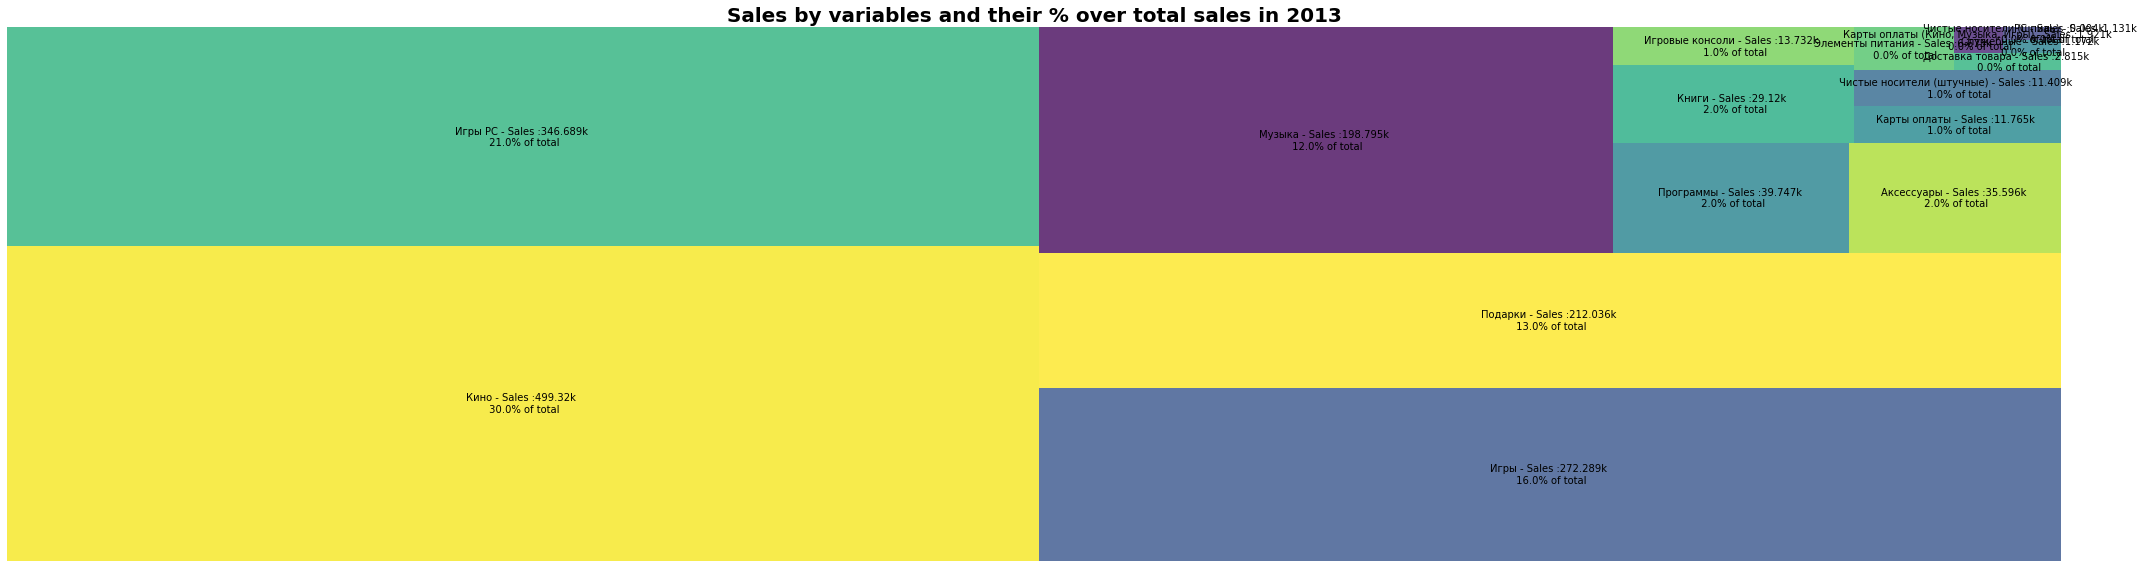

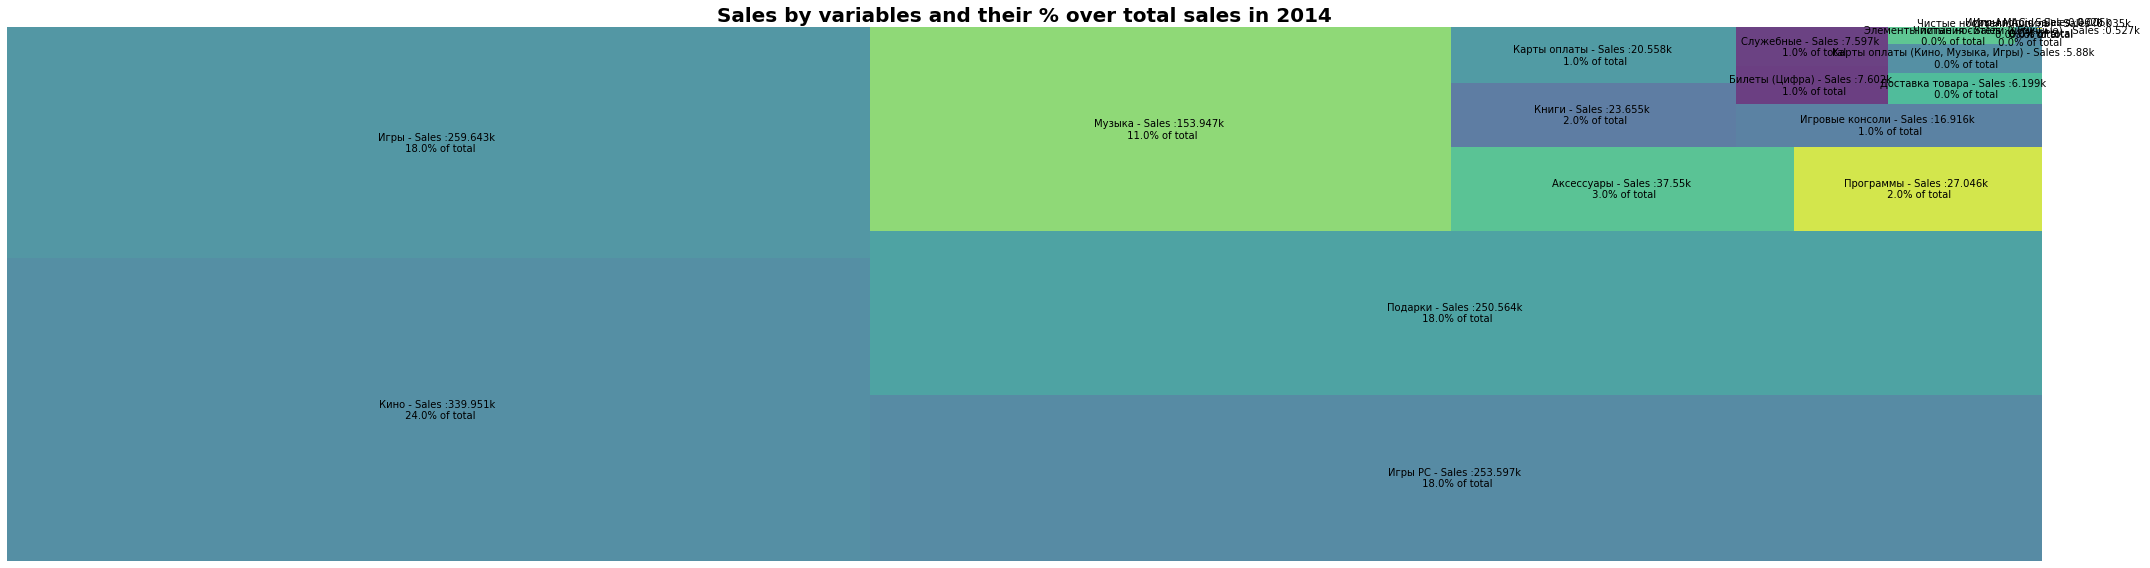

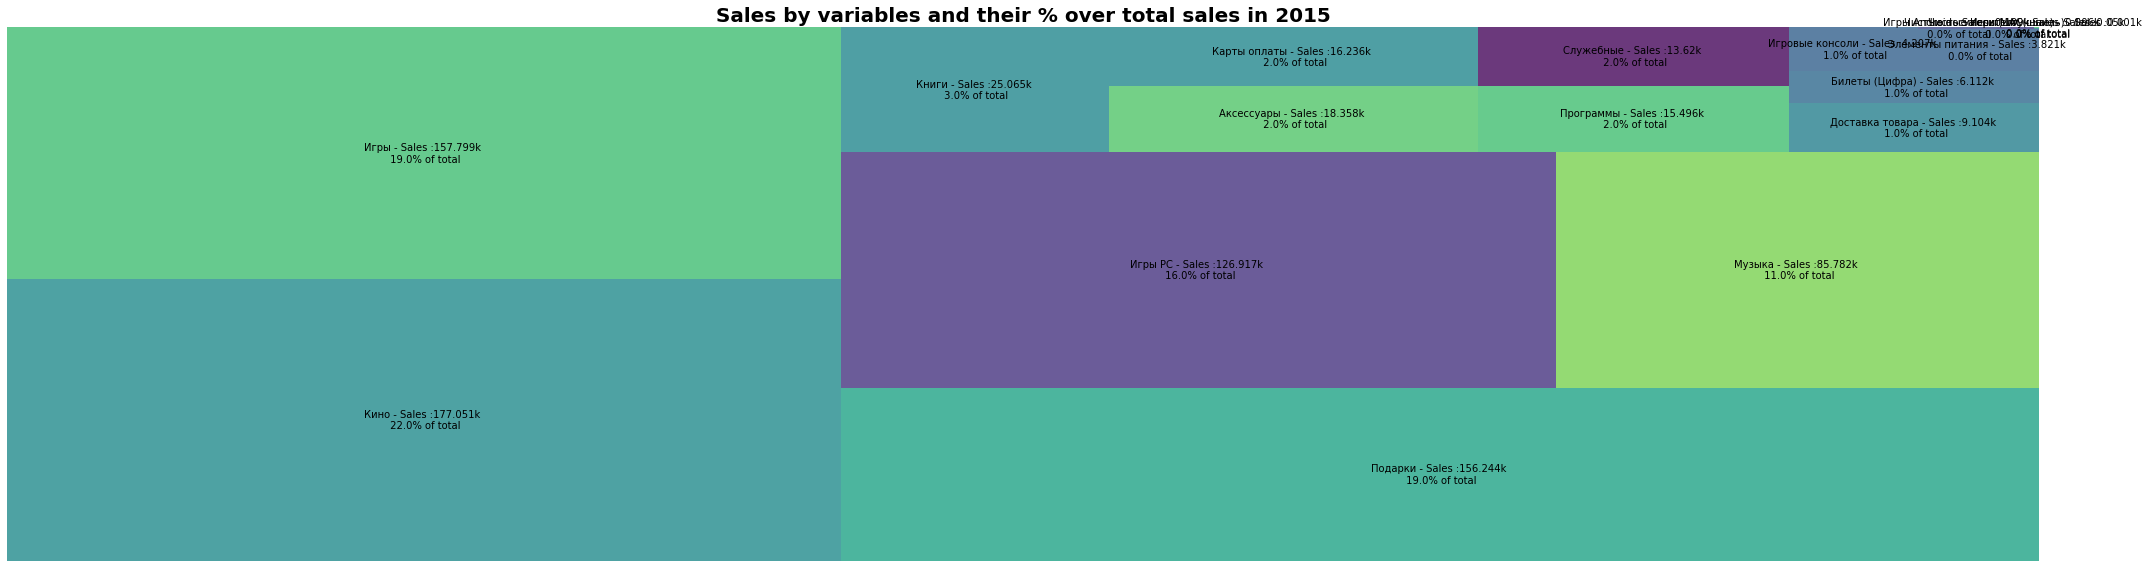

In [54]:
for y in [2013,2014,2015]:
    heatmap_year(y,['item_cnt_day','type'])

In [55]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "type_code" ] = "Игры"
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats['type_code2'] = cats.type_code.apply(lambda x: x if (x in category) else "etc")
#cats['type_code2'] = LabelEncoder().fit_transform(cats.type_code2)

CPU times: user 3.58 s, sys: 1.02 s, total: 4.6 s
Wall time: 4.12 s


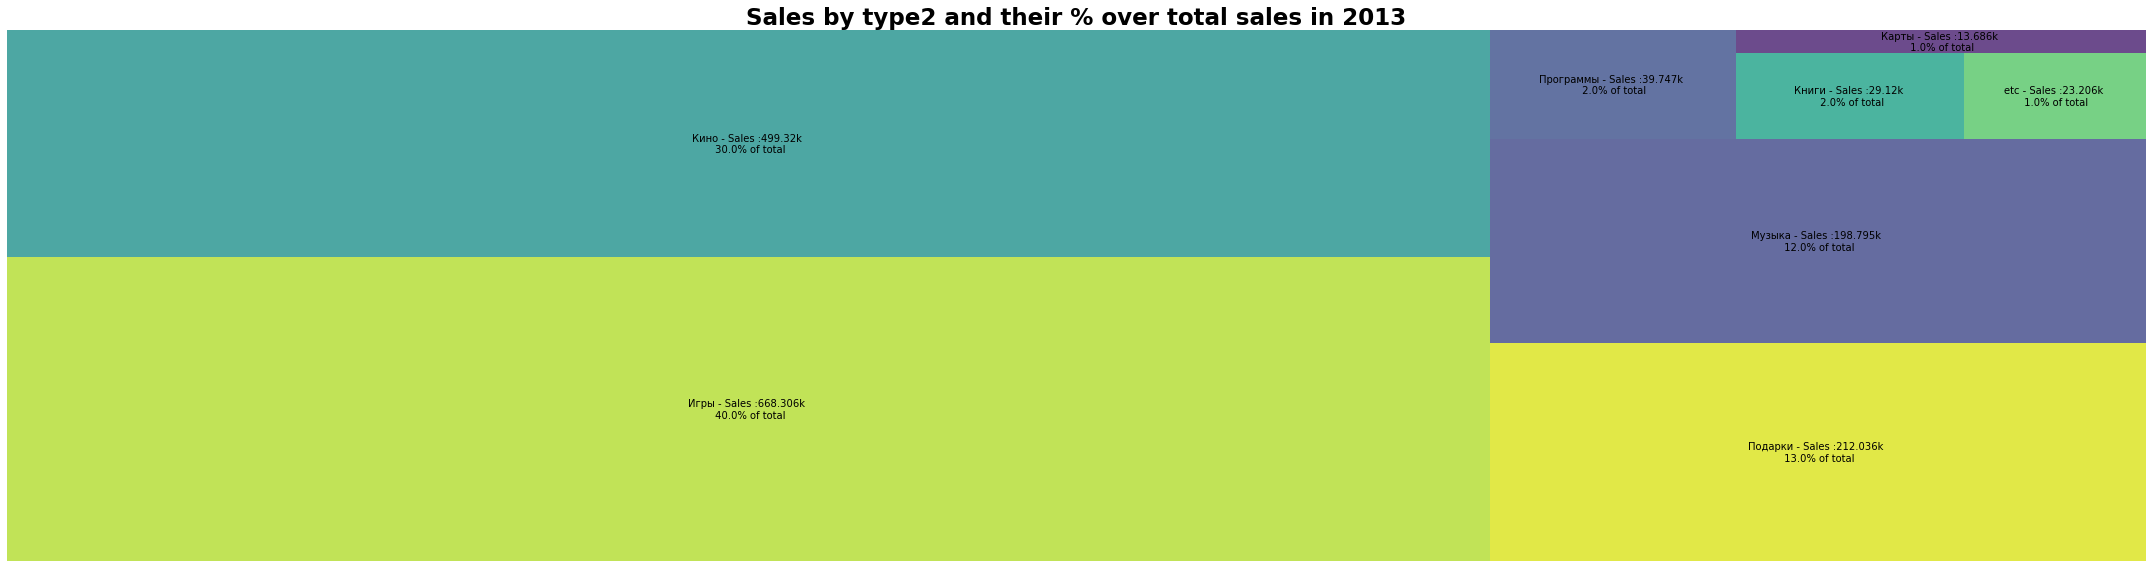

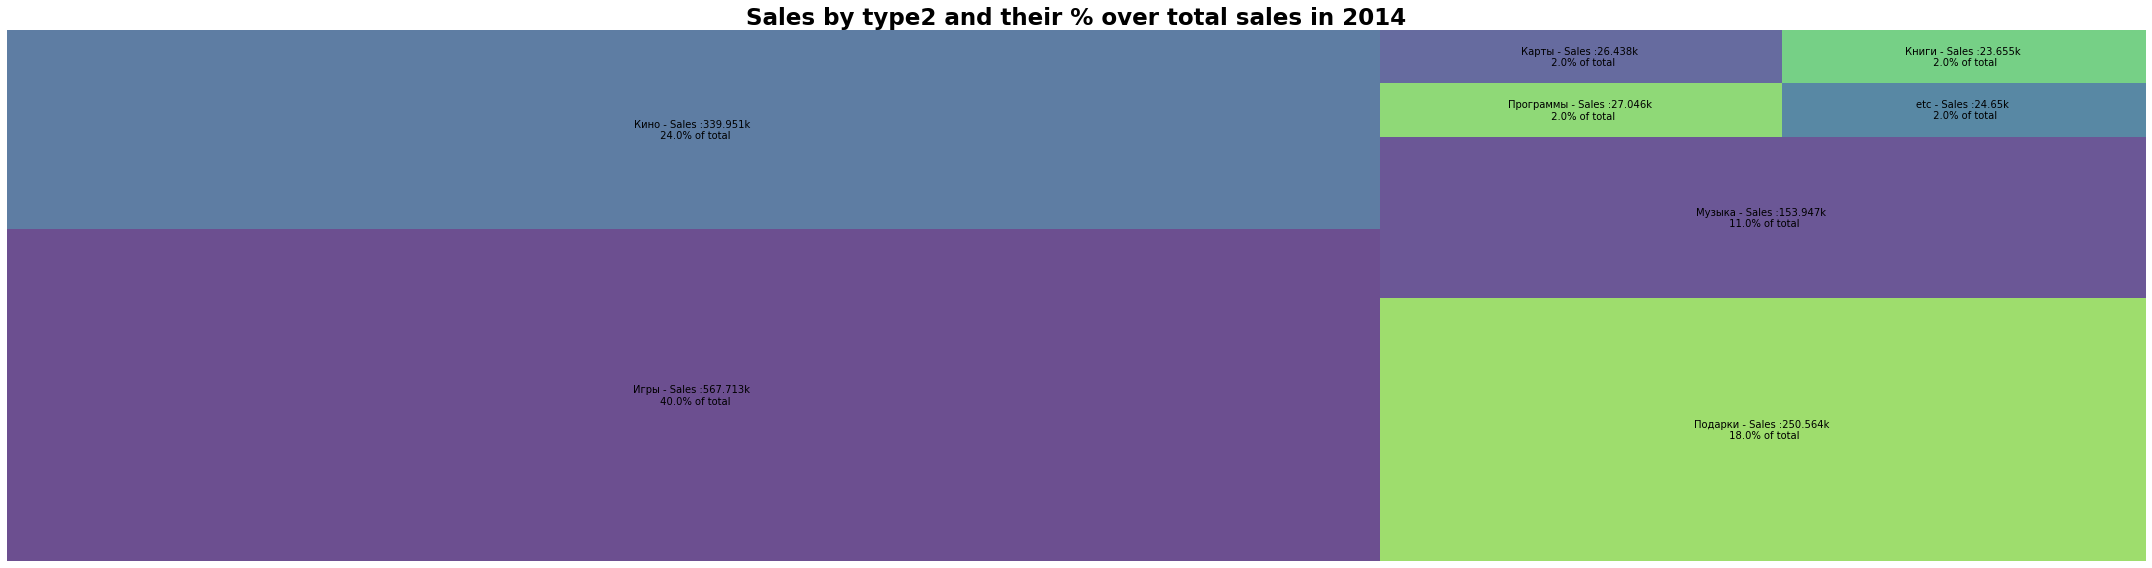

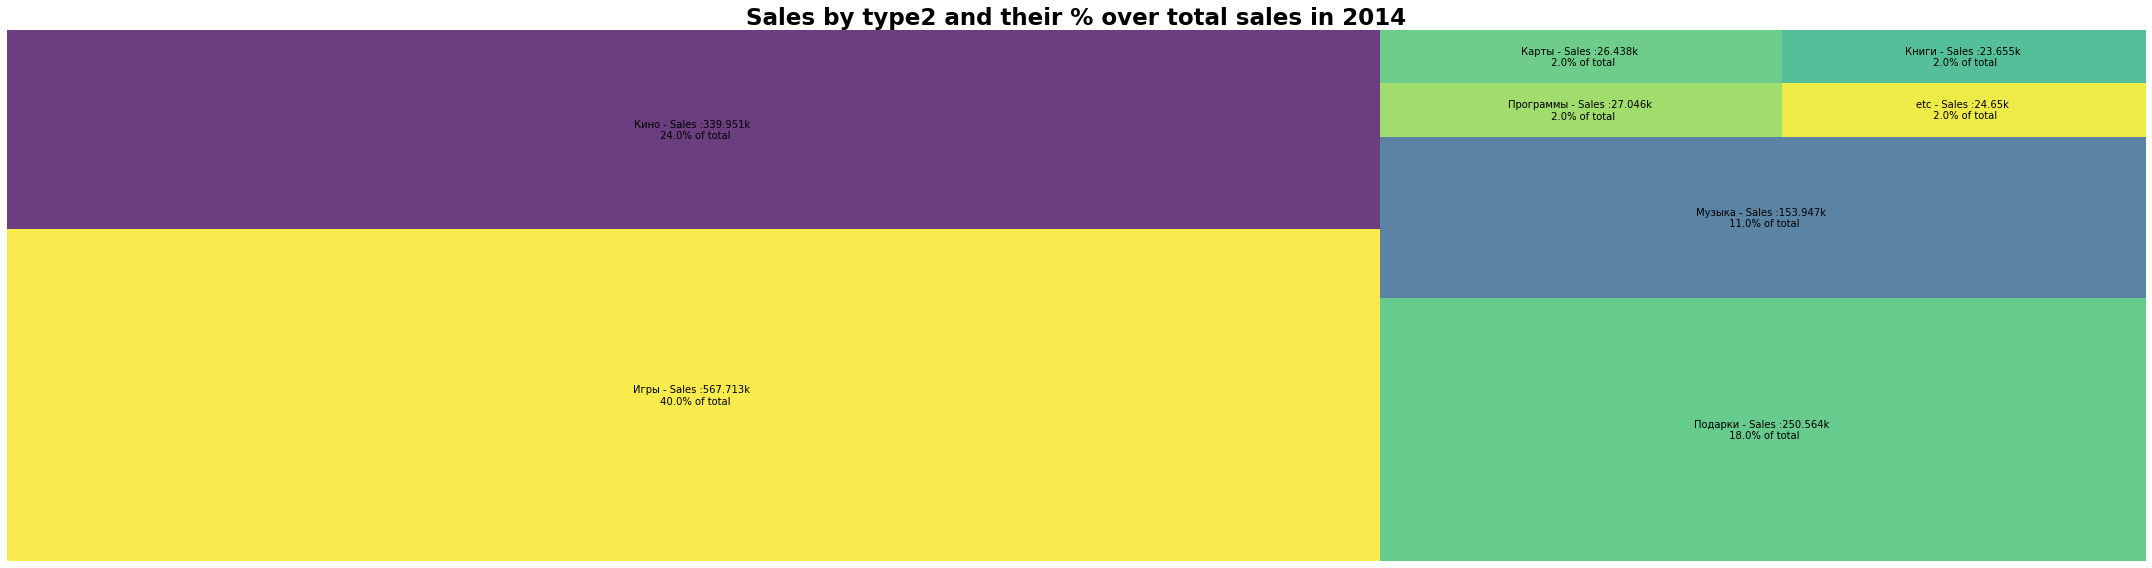

In [56]:
%%time
tmp = pd.merge(df,cats, on=["item_category_id"], how='left')
short_df = tmp[tmp["YEAR"] == 2013][["item_cnt_day", "type_code2"]]
short_df = short_df.groupby("type_code2")["item_cnt_day"].sum().to_frame()
short_df.sort_values("item_cnt_day", ascending = False, inplace = True)

my_values = short_df["item_cnt_day"]
my_pct = short_df["item_cnt_day"]/short_df["item_cnt_day"].sum()
labels = ['{} - Sales :{}k \n {}% of total'.format(city, sales/1000, round(pct, 2)*100) for city, sales, pct in zip(short_df.index, my_values, my_pct)]
plt.figure(figsize = (30, 8))
squarify.plot(sizes = my_values, label = labels,  alpha = 0.8)
plt.title("Sales by type2 and their % over total sales in 2013",fontsize = 23, fontweight = "bold")

plt.axis('off')
plt.tight_layout()
short_df = tmp[tmp["YEAR"] == 2014][["item_cnt_day", "type_code2"]]
short_df = short_df.groupby("type_code2")["item_cnt_day"].sum().to_frame()
short_df.sort_values("item_cnt_day", ascending = False, inplace = True)

my_values = short_df["item_cnt_day"]
my_pct = short_df["item_cnt_day"]/short_df["item_cnt_day"].sum()
labels = ['{} - Sales :{}k \n {}% of total'.format(city, sales/1000, round(pct, 2)*100) for city, sales, pct in zip(short_df.index, my_values, my_pct)]
plt.figure(figsize = (30, 8))
squarify.plot(sizes = my_values, label = labels,  alpha = 0.8)
plt.title("Sales by type2 and their % over total sales in 2014",fontsize = 23, fontweight = "bold")

plt.axis('off')
plt.tight_layout()
short_df = tmp[tmp["YEAR"] == 2014][["item_cnt_day", "type_code2"]]
short_df = short_df.groupby("type_code2")["item_cnt_day"].sum().to_frame()
short_df.sort_values("item_cnt_day", ascending = False, inplace = True)

my_values = short_df["item_cnt_day"]
my_pct = short_df["item_cnt_day"]/short_df["item_cnt_day"].sum()
labels = ['{} - Sales :{}k \n {}% of total'.format(city, sales/1000, round(pct, 2)*100) for city, sales, pct in zip(short_df.index, my_values, my_pct)]
plt.figure(figsize = (30, 8))
squarify.plot(sizes = my_values, label = labels,  alpha = 0.8)
plt.title("Sales by type2 and their % over total sales in 2014",fontsize = 23, fontweight = "bold")

plt.axis('off')
plt.tight_layout()

# Subtype effect
### Fix the years (2013, 2014, 2015) and sum item_cnt_day group by subtype.

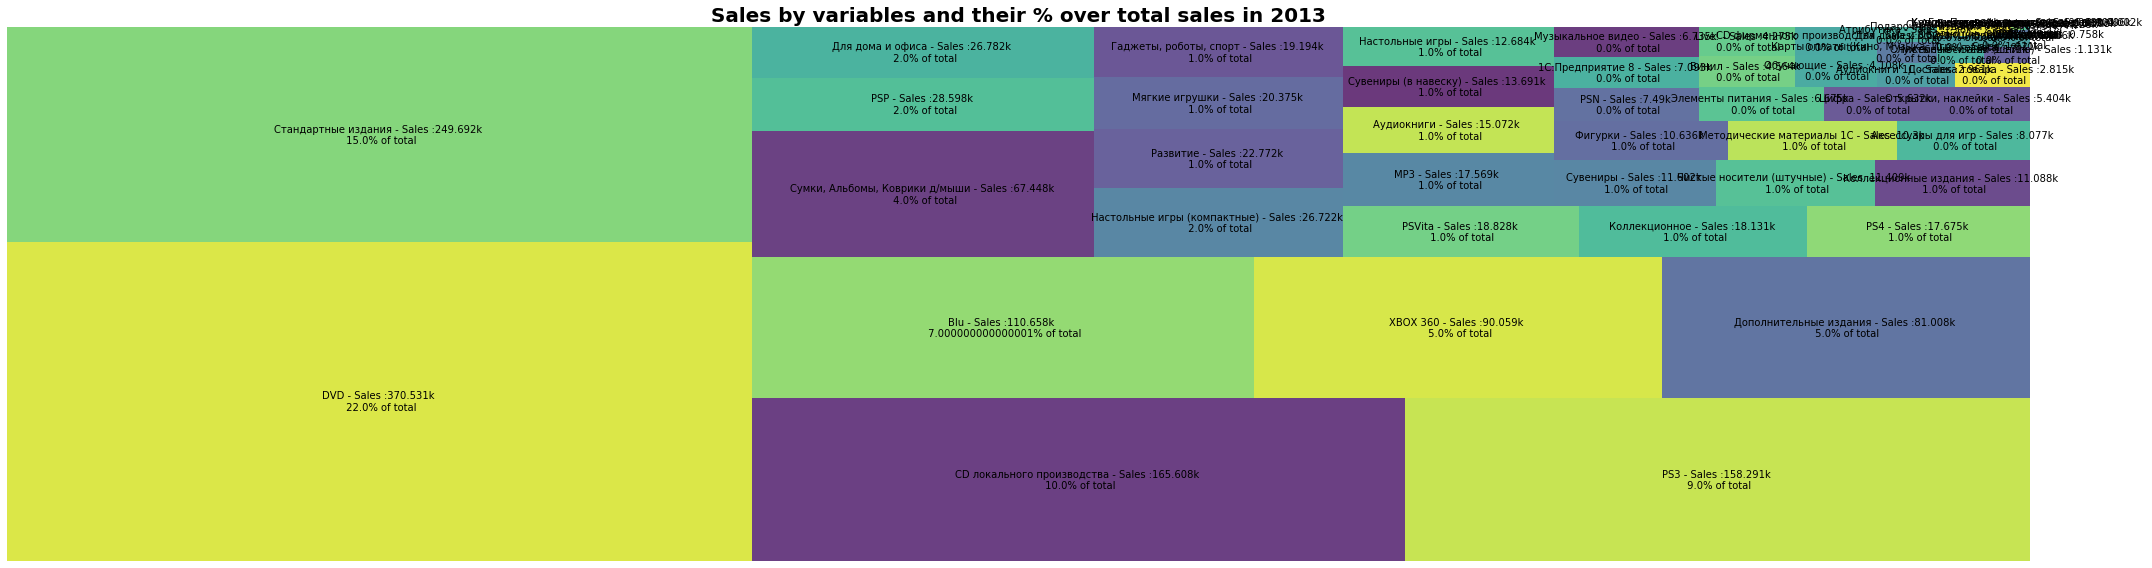

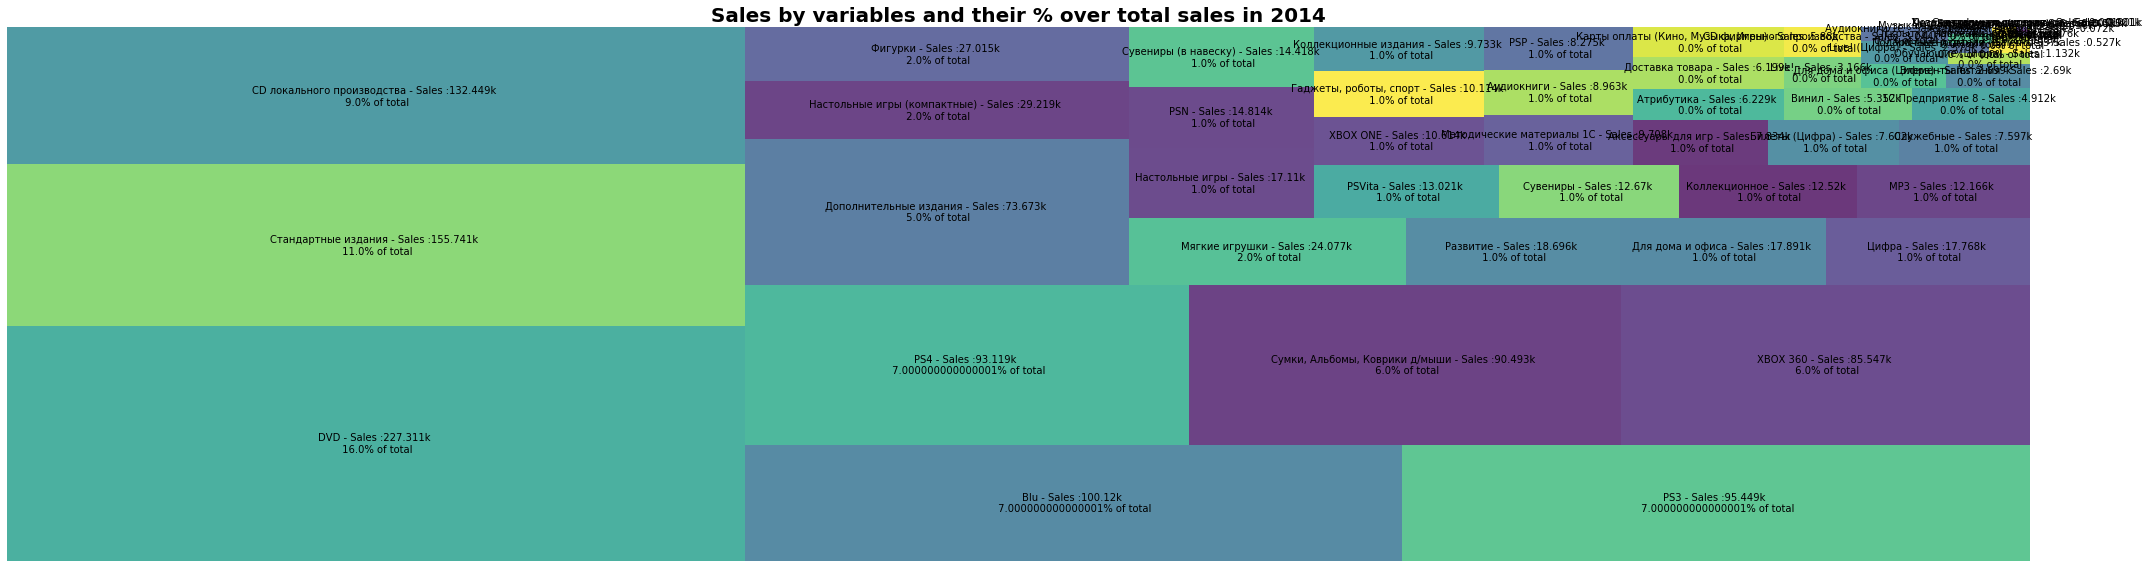

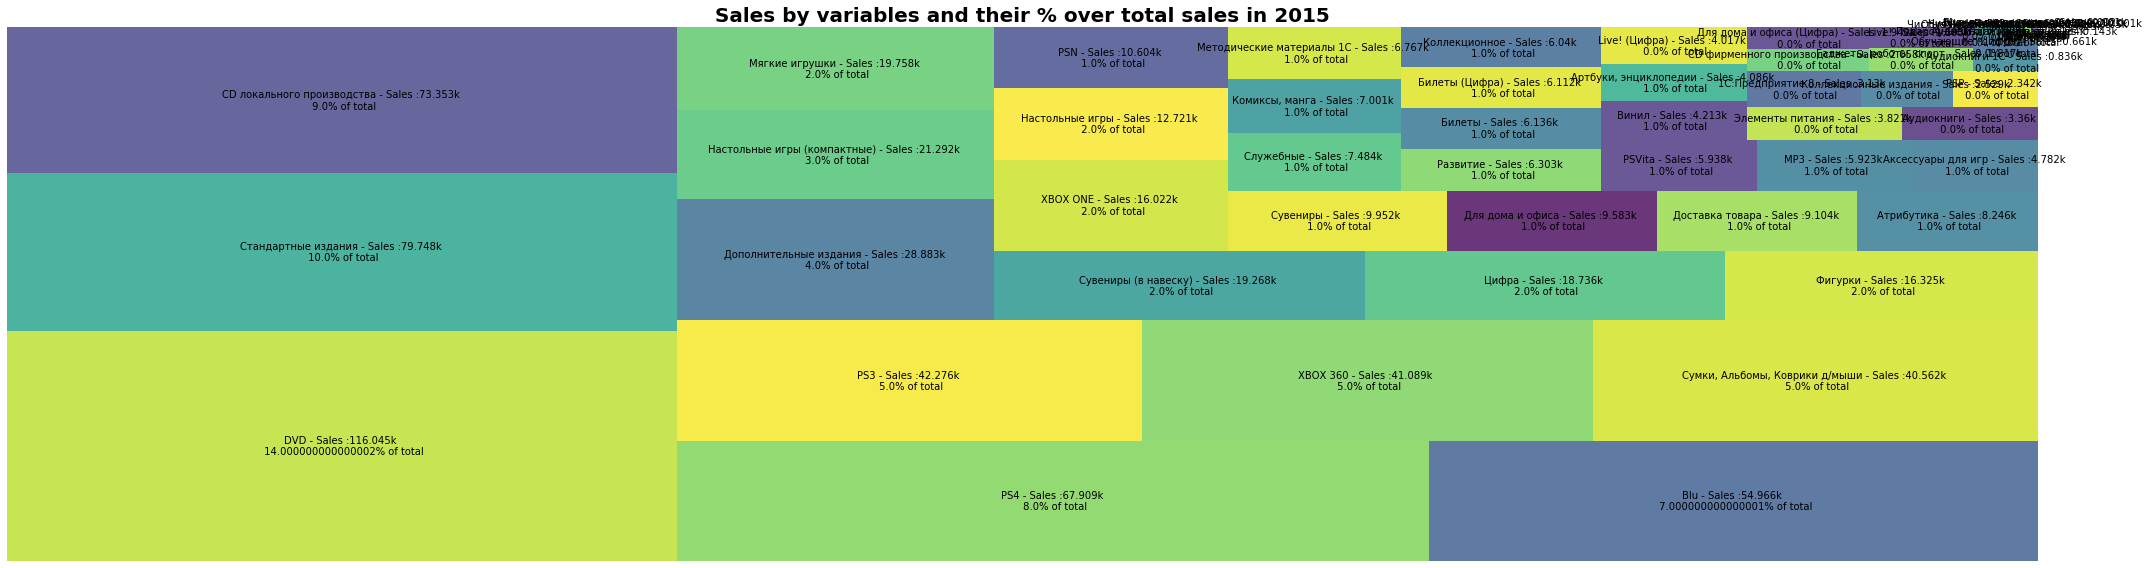

In [57]:
for y in [2013,2014,2015]:
    heatmap_year(y,['item_cnt_day','subtype'])

# Shop_category effect
### Fix the years (2013, 2014, 2015) and sum item_cnt_day group by shop_category.

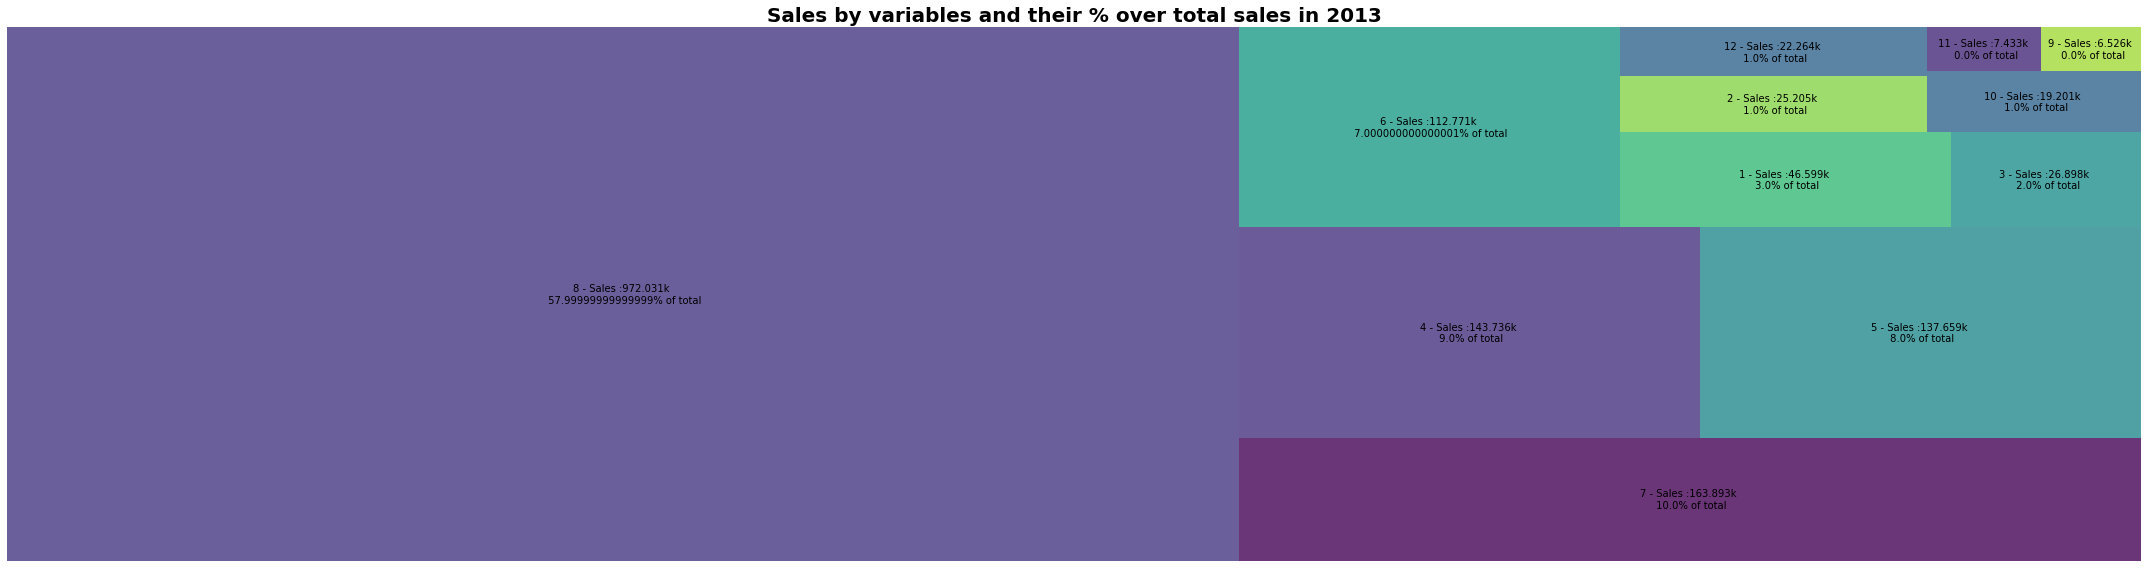

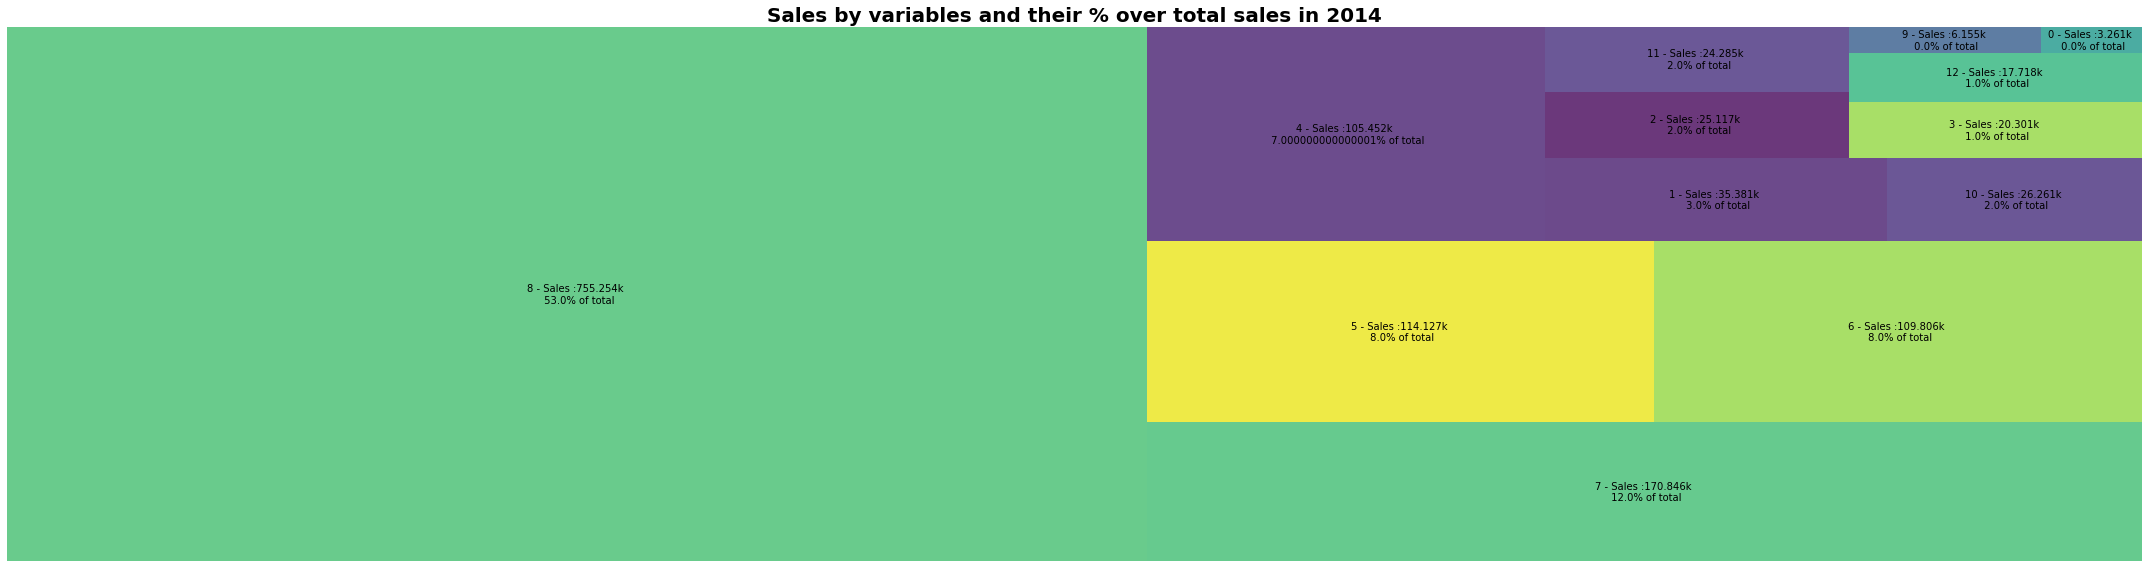

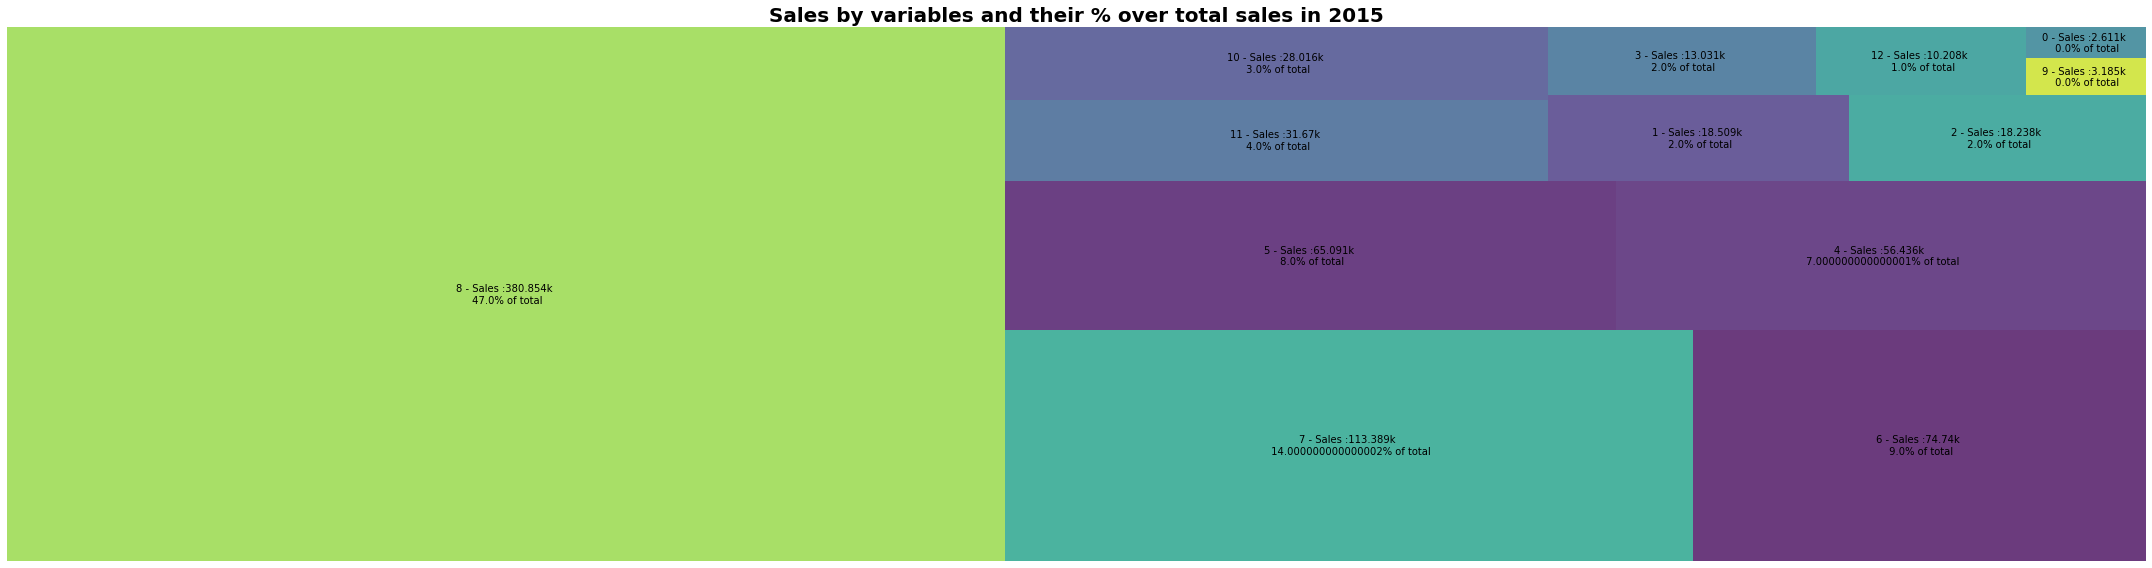

In [58]:
for y in [2013,2014,2015]:
    heatmap_year(y,['item_cnt_day','shop_category'])

# Joint effect

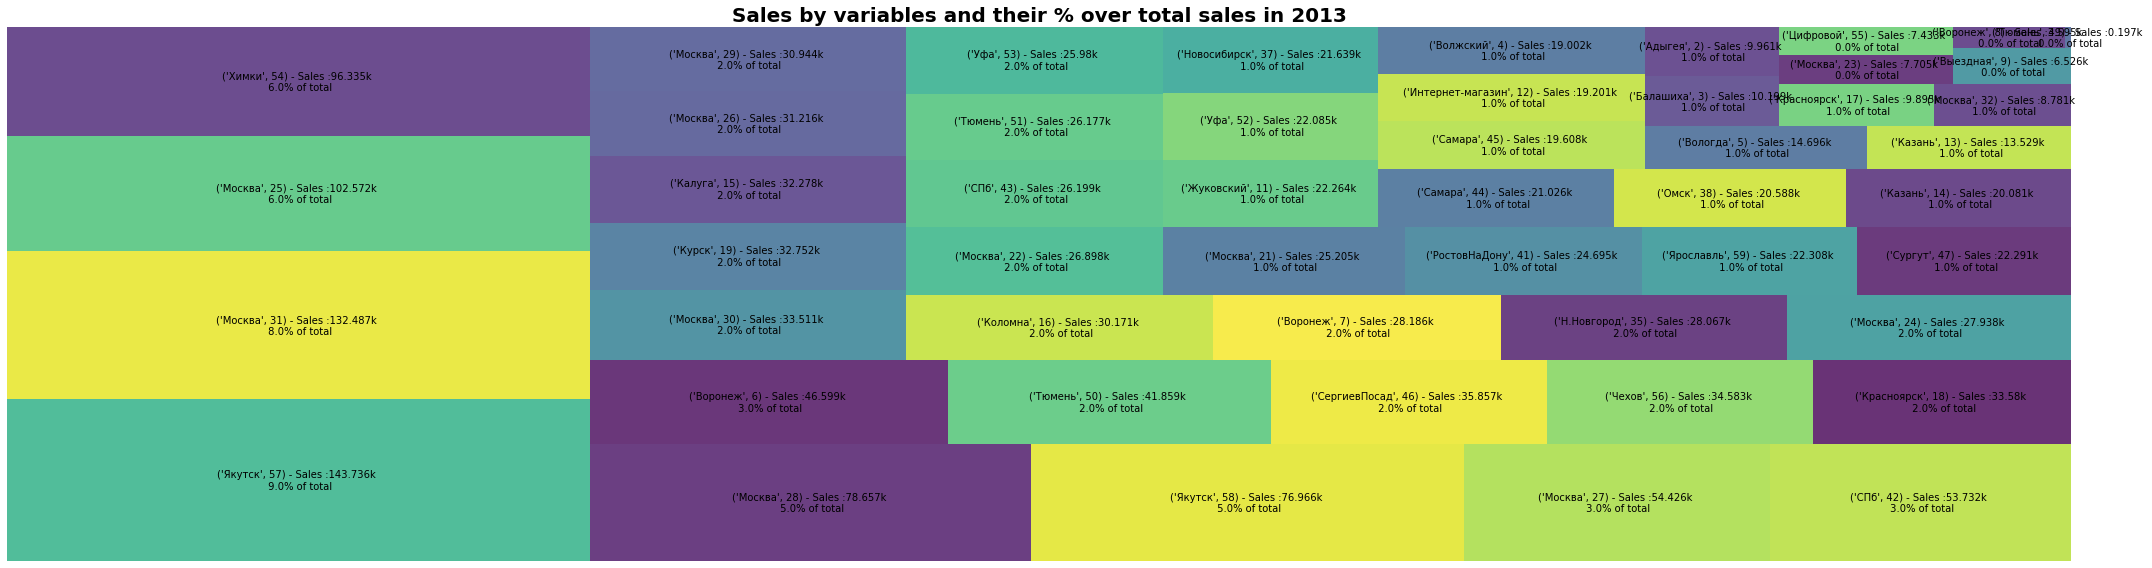

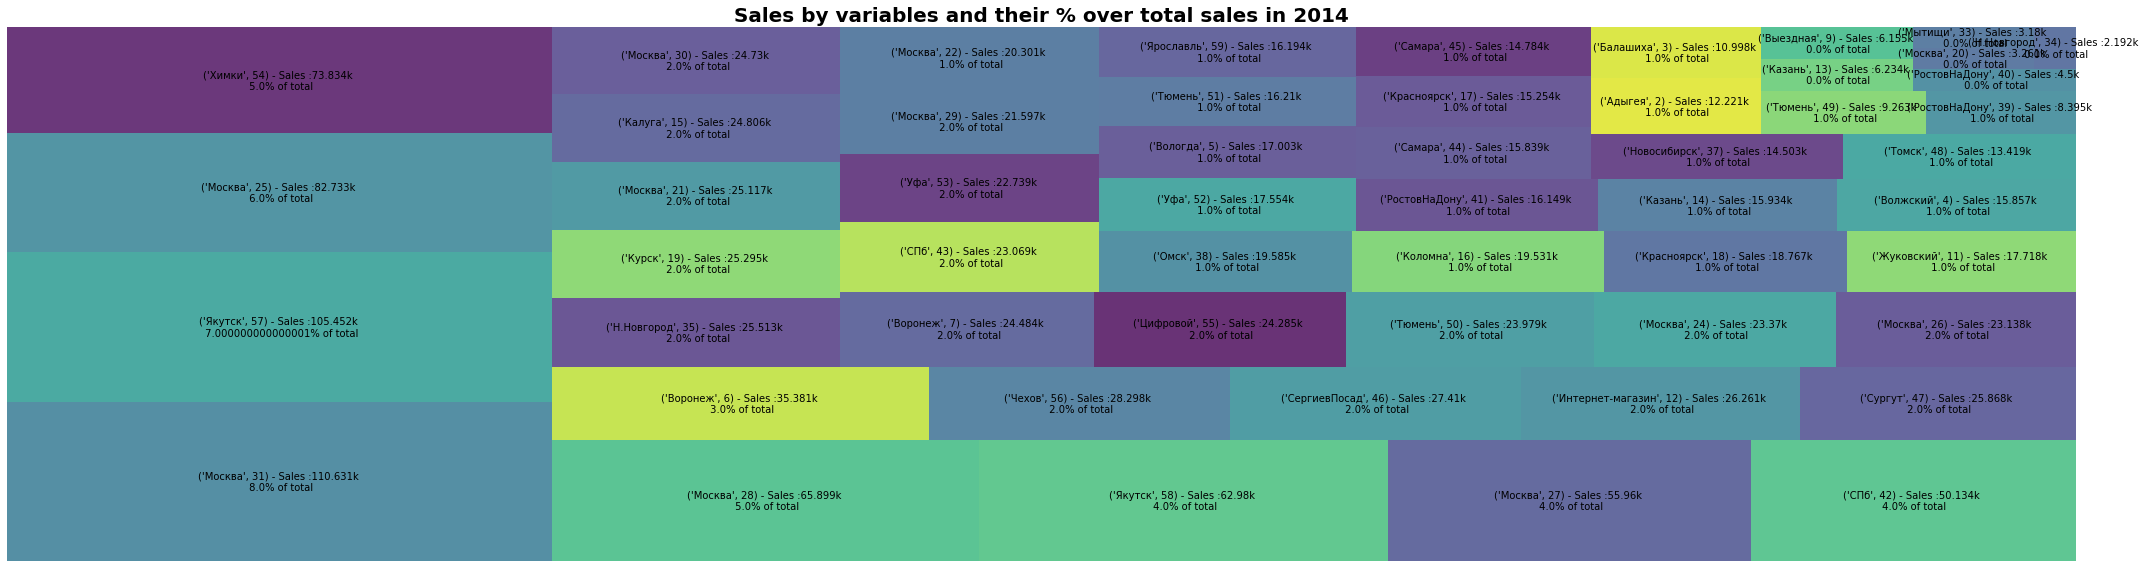

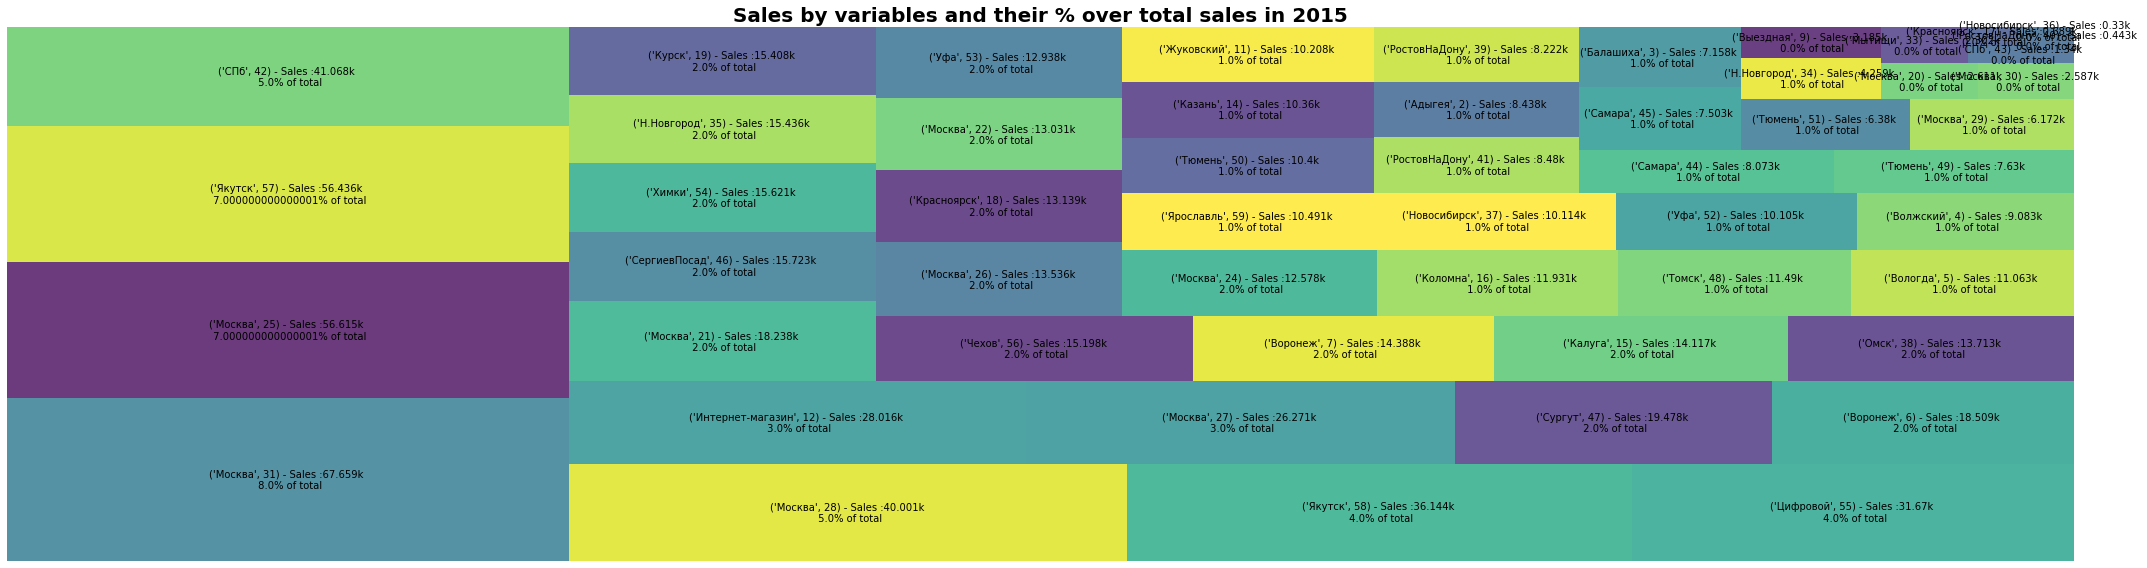

In [59]:
for y in [2013,2014,2015]:
    heatmap_year(y,['item_cnt_day','city','shop_id'])

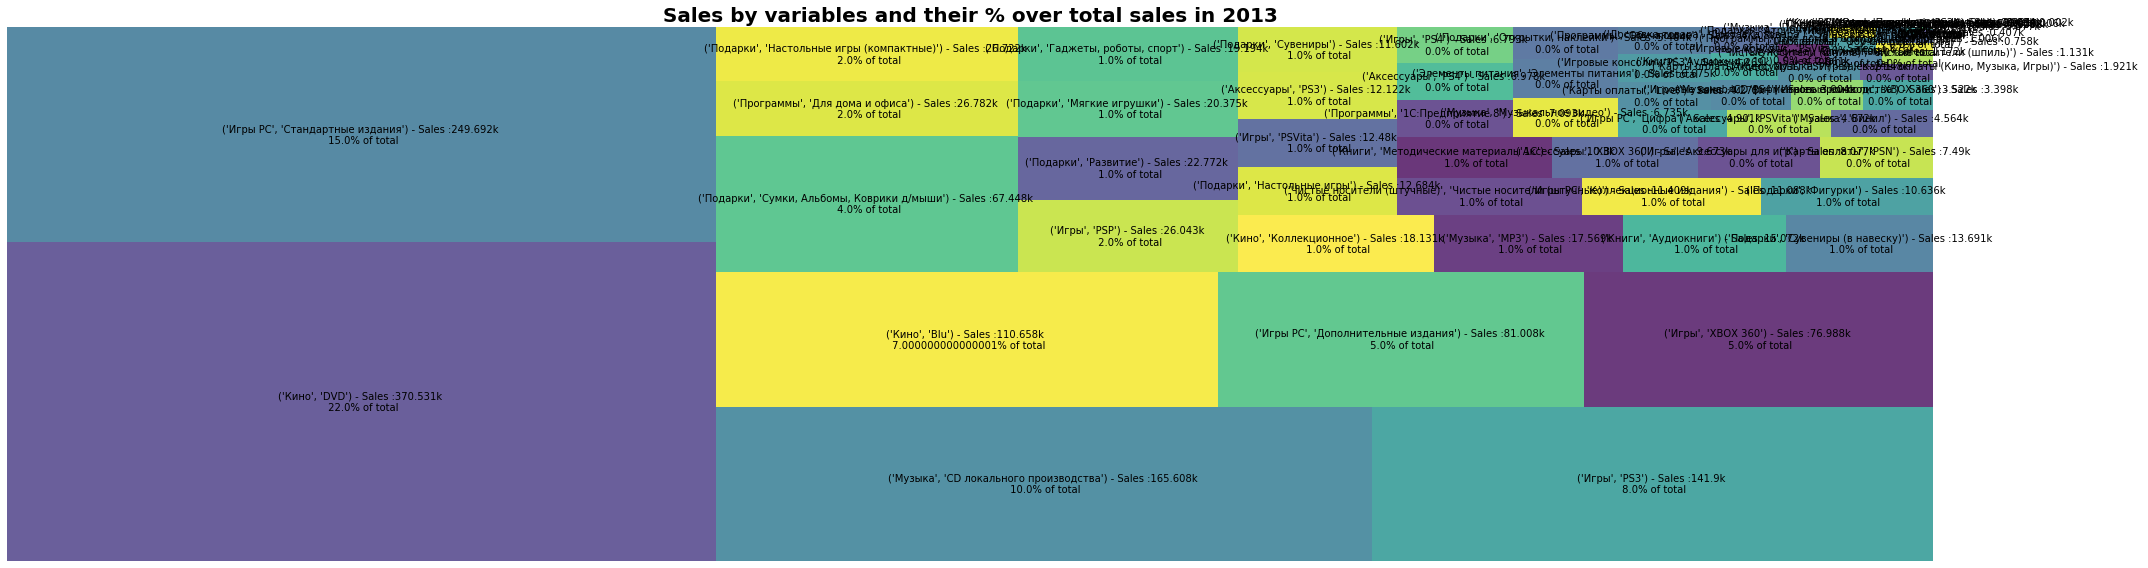

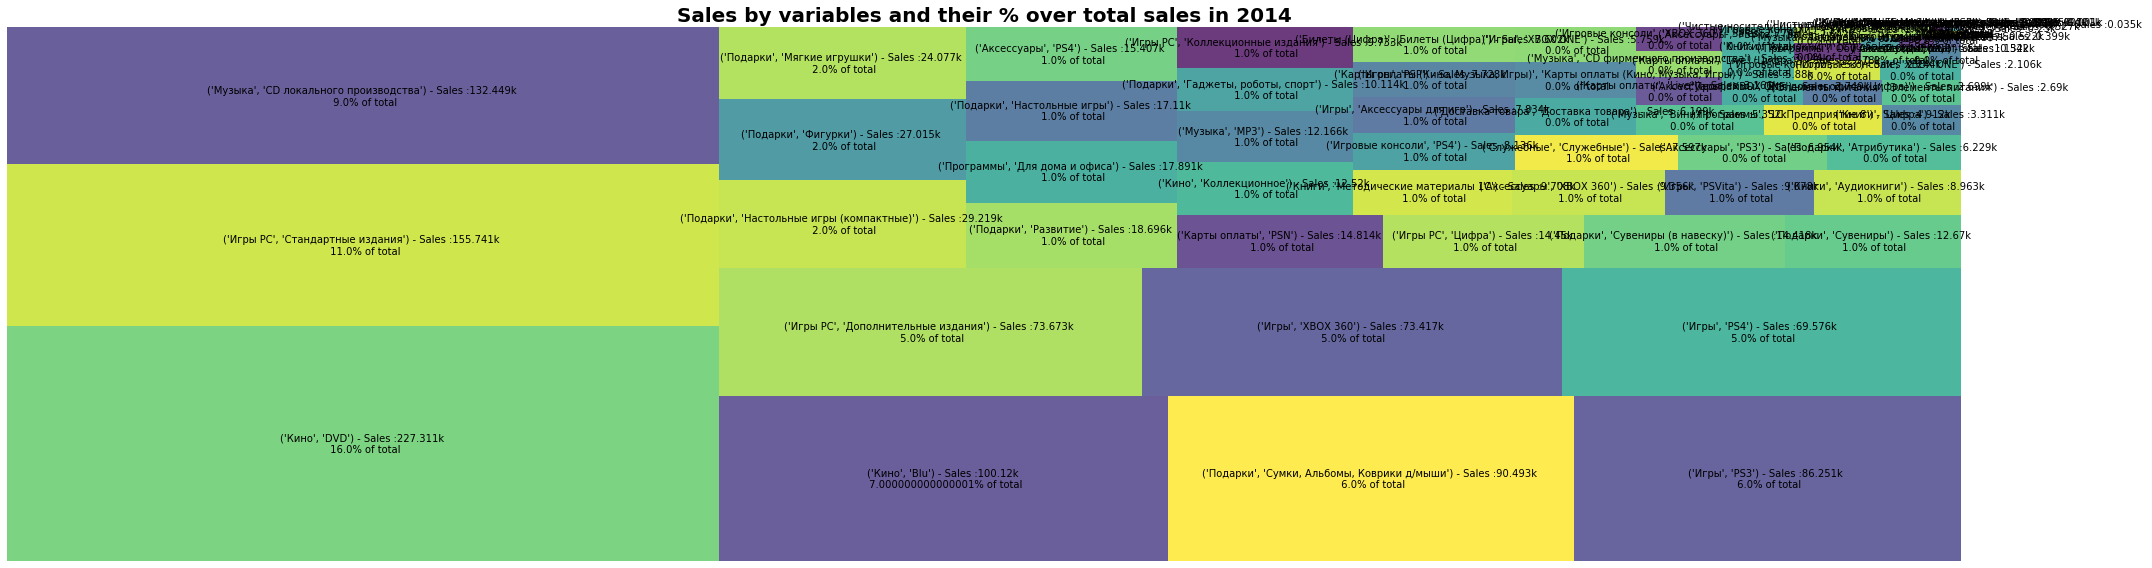

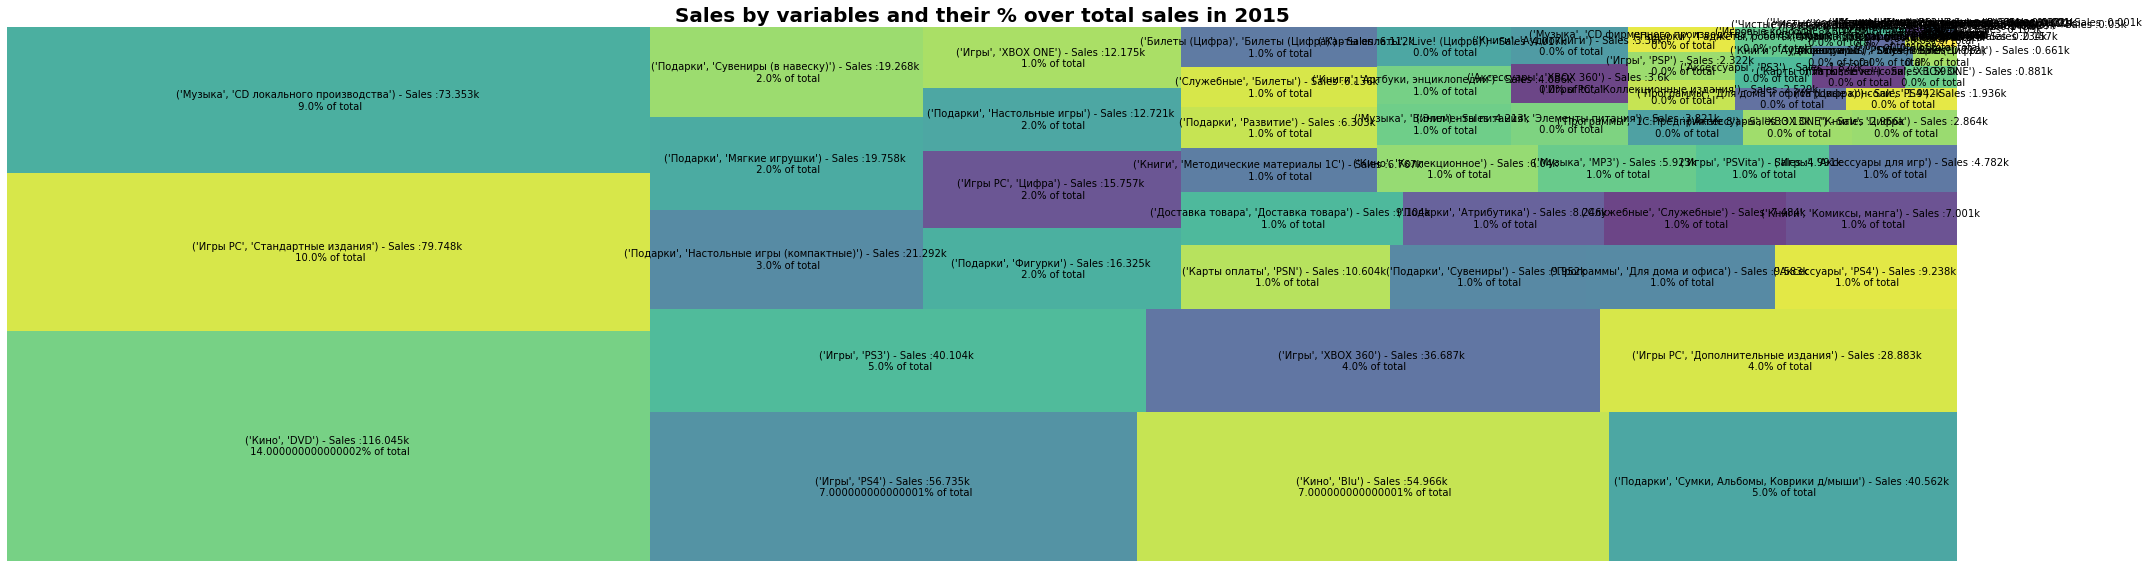

In [60]:
for y in [2013,2014,2015]:
    heatmap_year(y,["item_cnt_day",'type','subtype'])

# Price and Revenue effect

CPU times: user 7.2 s, sys: 201 ms, total: 7.4 s
Wall time: 6.87 s


<Figure size 720x288 with 0 Axes>

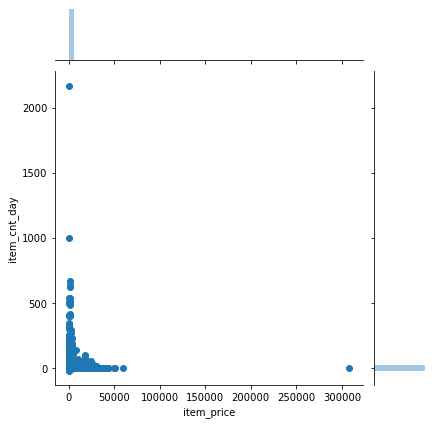

In [61]:
%%time
plt.figure(figsize = (10,4))
sns.jointplot(x = "item_price", y = "item_cnt_day", data = df);

CPU times: user 7.65 s, sys: 190 ms, total: 7.84 s
Wall time: 7.46 s


<Figure size 720x288 with 0 Axes>

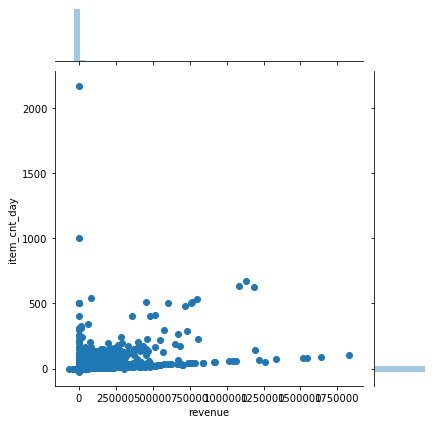

In [62]:
%%time
df['revenue'] = df['item_cnt_day']*df['item_price']
plt.figure(figsize = (10,4))
sns.jointplot(x = "revenue", y = "item_cnt_day", data = df);

<Figure size 936x576 with 0 Axes>

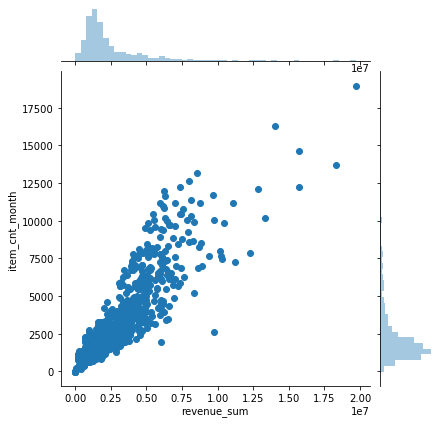

In [63]:
plt.figure(figsize=(13,8))
tmp = df.groupby( ["date_block_num", "shop_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

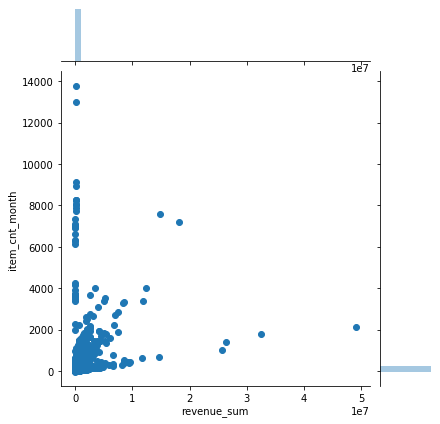

In [64]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "item_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

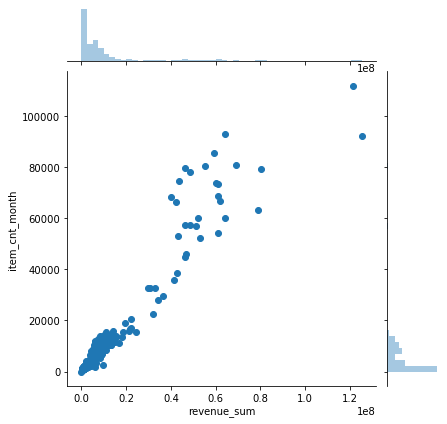

In [65]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "shop_category"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

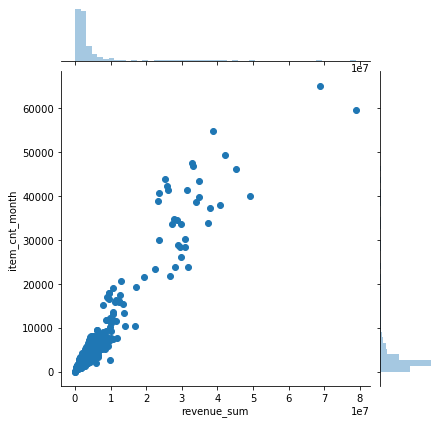

In [66]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "city_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

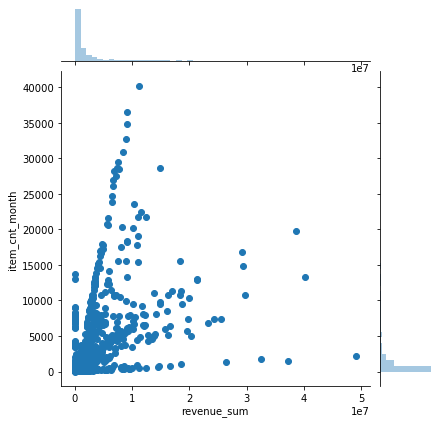

In [67]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "item_category_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

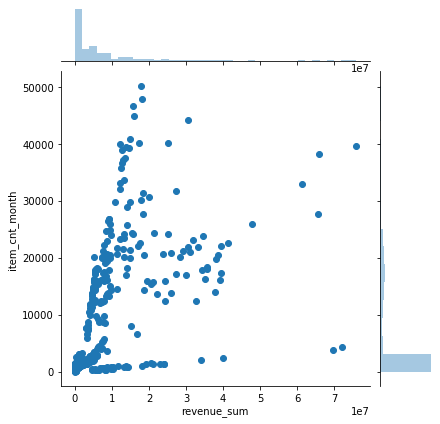

In [68]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "type"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

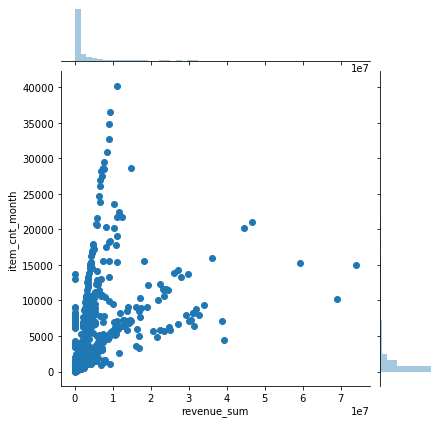

In [69]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "subtype"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

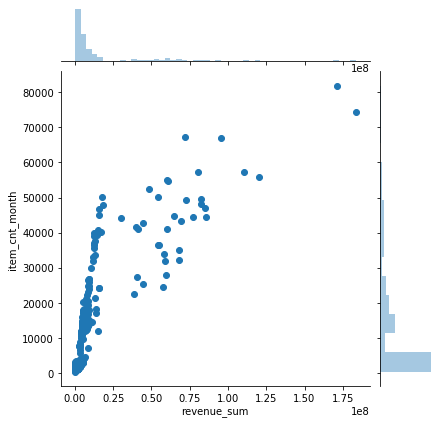

In [70]:
tmp = pd.merge(df,cats, on=["item_category_id"], how='left')
plt.figure(figsize = (10,4))
tmp = tmp.groupby( ["date_block_num", "type_code2"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

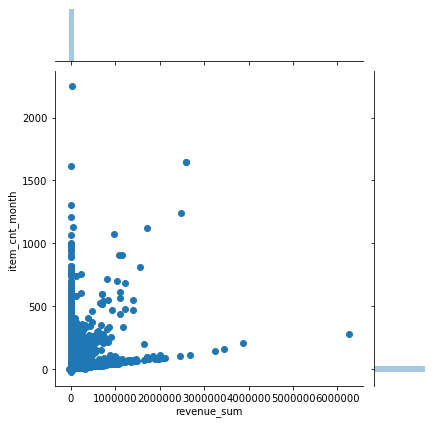

In [71]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "shop_id","item_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

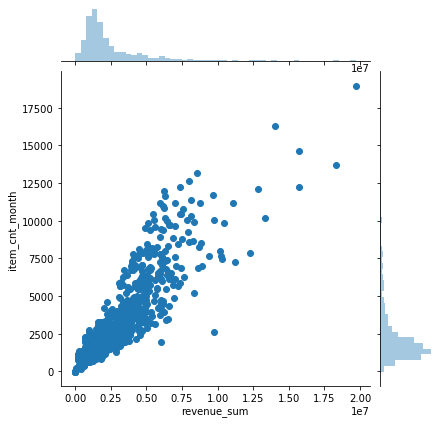

In [72]:
tmp = df.groupby( ["date_block_num", "city_id", "shop_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
plt.figure(figsize = (10,4))
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

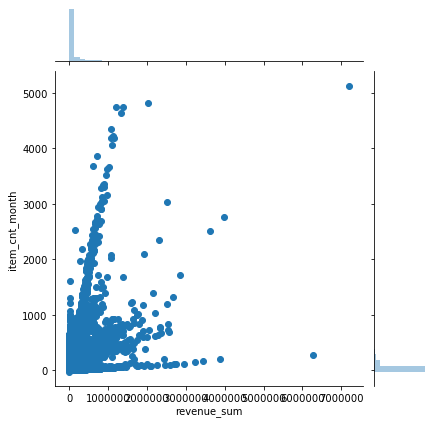

In [73]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "shop_id","item_category_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

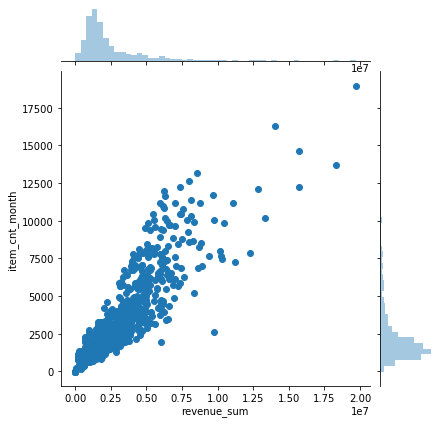

In [74]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num","shop_category","shop_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

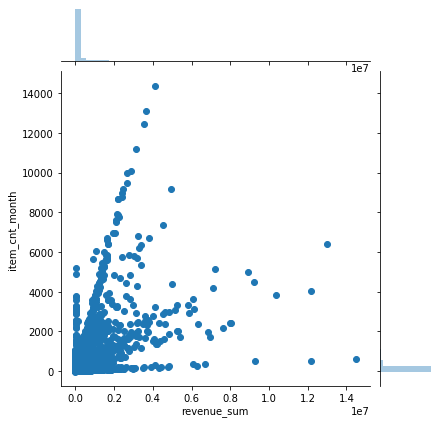

In [75]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "city_id","item_category_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

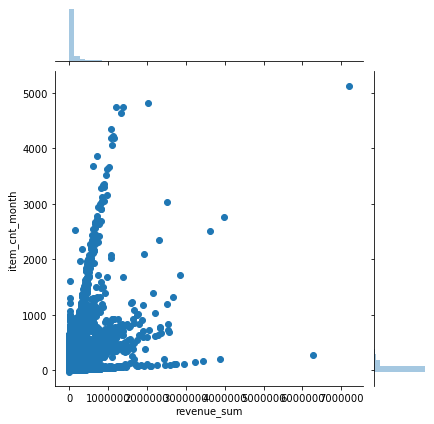

In [76]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num", "city_id","shop_id","type","subtype"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);

<Figure size 720x288 with 0 Axes>

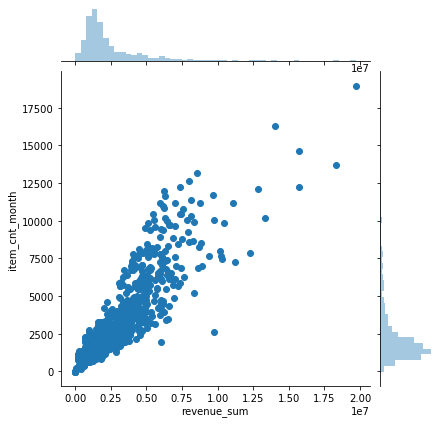

In [77]:
plt.figure(figsize = (10,4))
tmp = df.groupby( ["date_block_num","city_id","shop_category","shop_id"] ).agg( {"item_cnt_day": ["sum"],"revenue":["sum"]} )
tmp.columns = ["item_cnt_month","revenue_sum"]
sns.jointplot(x = "revenue_sum", y = "item_cnt_month", data = tmp);